This is the first part of a walkthough of **grt123**'s [winning submission](https://www.kaggle.com/c/data-science-bowl-2017/discussion/32555) for the [Kaggle Data Science Bowl 2017](https://www.kaggle.com/c/data-science-bowl-2017). This walkthrough is entirely based off their implementation, which can be found [here](https://github.com/lfz/DSB2017).

The goal of this walkthrough is to go line-by-line and see exactly what they did. All of their code is in their repository of course, but unless you're extremely familiar with the type of 3d manipulation and segmentation that they use it won't be clear what each step is doing. 

The best way to learn is to stop at every line and explain the process, using visualizations to see before and after. That in itself is extremely time-consuming... so I've done it for you, in the hopes that this makes it easier for data scientists of all levels to understand and replicate their process for your own potentially life-saving applications.

Additionally, they use alot of really cool image processing tricks that I think would be useful to keep in your back pocket for any similar domain.

I also include an overview of CT (computed tomography) scanning from a physical perspective, including interpretations of the metric we'll be dealing with, Hounsfield Units.

If you've seen Guido Zuidhof's [Full-Preprocessing-Tutorial](https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial) kernel, the first parts of this should be familiar (in fact, some of it is the same code).

However, grt123 extend far, far beyond this and the result is an **extremely** robust segmentation process.

Note: My explanations for parts of this process are my best interpretation of why they are done. I think I've done a good job providing intuition, but if you find explanations that are lacking or wrong please let me know.

## Setup

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from PIL import Image
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.ndimage.morphology import binary_dilation,generate_binary_structure
from skimage.morphology import convex_hull_image
from scipy.ndimage.interpolation import zoom
from scipy.io import loadmat
import warnings
from multiprocessing import Pool, cpu_count
from functools import partial

In [63]:
%matplotlib inline

Make sure to set this to your own path.

In [4]:
PATH = "/data/datasets/dsb17/stage1"

## Kaggle Stage1 Dataset

The dataset for this competition comes in a directory **stage1**. Each subdirectory corresponds to a unique patient id. This is the same id used in the target csv file.

In [5]:
patients = os.listdir(PATH)

In [7]:
patients[:3]

['cc1bf5250466173086887675dff499c3',
 '6541df84fd779ba6513a530c128f4e9b',
 '56462ba8833fc842d16be7e311214404']

Each subdirectory contains **.dcm** (**DICOM**) files commonly used in medical imaging. Each file is an axial (in the z-axis) **slice** of the whole CT-scan.

In [8]:
dicoms = os.listdir(os.path.join(PATH,patients[0]))

In [9]:
dicoms[:3]

['4cdf8c3c57b51a69a75a64c3d01f2e2a.dcm',
 '40b19aad9c3515e57b47211abedf67bb.dcm',
 '3f8a54f1a15712f1d343f11a96a72351.dcm']

### Load Scan

We're going to use the **pydicom** library to open each .dcm file for a specific patient.

In [79]:
patient_0_path = os.path.join(PATH,patients[0])

In [80]:
patient_0_path

'/data/datasets/dsb17/stage1/cc1bf5250466173086887675dff499c3'

In [81]:
patient_0_slices = [dicom.read_file(patient_0_path + '/' + s) for s in os.listdir(patient_0_path)]

We can see the dicom object has a variety of attributes loaded from the file.

In [21]:
patient_0_slices[0]

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113654.2.55.307379961410267527176263105844702557870
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0010) Patient's Name                      PN: 'cc1bf5250466173086887675dff499c3'
(0010, 0020) Patient ID                          LO: 'cc1bf5250466173086887675dff499c3'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 000d) Study Instance UID                  UI: 2.25.12107064498001929259600128628671457914481002513457466487082
(0020, 000e) Series Instance UID                 UI: 2.25.10349267033746511300364957700565014670145275749146907199004
(0020, 0011) Series Number                       IS: '2'
(0020, 0012) Acquisition Number            

In [82]:
patient_0_slice = patient_0_slices[0]

Remember, each DICOM file is an axial slice, so to put together the whole picture we need to put them in the right order.

In [24]:
patient_0_slice.ImagePositionPatient

['-194.100006', '-190.000000', '-10.250000']

The <tt>ImagePositionPatient</tt> attribute contains reference points of where this slice is, so we're going to sort by the last entry (which is the z-coordinate) to order appropriately.

In [83]:
patient_0_slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))

Occasionally, there will be an edge case (like patient 696) where an image has multiple scans of the same place in space.

In [36]:
patient_696_path = os.path.join(PATH,patients[696]) 

In [37]:
patient_696_slices = [dicom.read_file(patient_696_path + '/' + s) for s in os.listdir(patient_696_path)]

In [40]:
patient_696_slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))

Note that these two slices are in the same position.

In [45]:
patient_696_slices[0].ImagePositionPatient

['-140.000000', '-144.699997', '-256.339996']

In [46]:
patient_696_slices[1].ImagePositionPatient

['-140.000000', '-144.699997', '-256.339996']

I imagine this happens when a scan makes multiple passes along the axial axis. In this instance, we need to figure out how many passes (copies) of each cross section there are.

In [47]:
sec_num = 2;
while patient_696_slices[0].ImagePositionPatient[2] == patient_696_slices[sec_num].ImagePositionPatient[2]:
    sec_num = sec_num+1;

In [48]:
sec_num

2

So in this instance, there are at most two scans of each slice. From this, we can infer the number of slices that are spatially unique.

In [49]:
slice_num = int(len(patient_696_slices)/sec_num)

Fortunately, the attribute <tt>InstanceNumber</tt> tracks the order of slices. If we sort by this, and take the first <tt>slice_num</tt> slices, we'll have all spatially unique slices from the first pass-through. 

In [51]:
patient_696_slices.sort(key = lambda x: int(x.InstanceNumber))

In [52]:
patient_696_slices = patient_696_slices[:slice_num]

Having this, we can now reorder as before.

In [54]:
patient_696_slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))

Each pydicom object also loads the scan as a 2d array. The dimensions represented by the pixels in this image can vary. Fortunately this information is stored in <tt>PixelSpacing</tt> in millimeters.

In [84]:
patient_0_slice.PixelSpacing

['0.742188', '0.742188']

What's missing is the vertical spacing between slices. We can find this difference by finding the difference in z values of the first two slices.

In [56]:
patient_0_slice_thickness = np.abs(patient_0_slices[0].ImagePositionPatient[2] - patient_0_slices[1].ImagePositionPatient[2]) 

In [57]:
patient_0_slice_thickness

2.5

Occasionally, this won't work. If that's the case we can just subtract <tt>SliceLocation</tt>

Finally, we'll store the slice thickness into a new attribute of the same name.

Putting this all together:

### Complete function

In [58]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    if slices[0].ImagePositionPatient[2] == slices[1].ImagePositionPatient[2]:
        sec_num = 2;
        while slices[0].ImagePositionPatient[2] == slices[sec_num].ImagePositionPatient[2]:
            sec_num = sec_num+1;
        slice_num = int(len(slices) / sec_num)
        slices.sort(key = lambda x:float(x.InstanceNumber))
        slices = slices[0:slice_num]
        slices.sort(key = lambda x:float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

## Hounsfield Units

As mentioned, the pydicom object contains an array representation of the scan in the attribute <tt>pixel_array</tt>.

In [85]:
patient_0_pixel_array = patient_0_slice.pixel_array

In [86]:
patient_0_pixel_array

array([[-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       ..., 
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024]], dtype=int16)

Let's take a look.

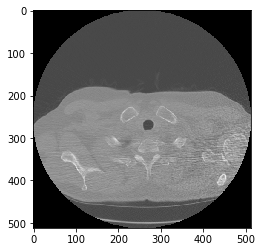

In [89]:
plt.imshow(patient_0_pixel_array, cmap = plt.cm.gray)

The values in the pixel array correspond to measurements of **radiodensity**. Put simply, this is a measurement of how absorbent a material is to X-rays. This naturally differs for different materials, so by measuring this we have a way of visualizing the interior tissues and so forth.

The actual values in the array elements are the **average linear attenuation coefficients** for the corresponding voxels.

How is this calculated for interior points?

### Aside: Extremely Simplified CT Overview

I'm not a radiologist, so don't place a bet on this explanation.

Let's look at the example of the **first generation CT-scanner**.

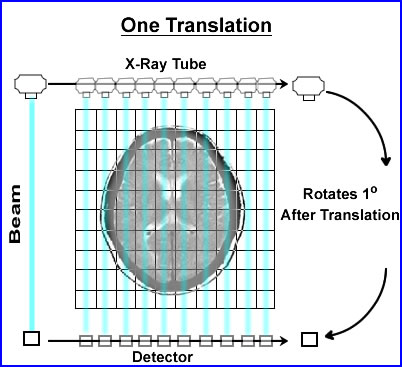

In [66]:
Image.open('ctfirstgen.jpg')

A collimated x-ray beam of known intensity is emitted through the patient. As that beam passes through various materials, x-ray photons are absorbed at various rates. The intensity is then measured by a photon detector on the other side, and we calculate how much the beam intensity was attenuated across a specific path. This apparatus translates across the space of interest.

What we want to do is take these measurements of attenuation across entire paths, and figure out the value of that attenuation in a discretized voxel grid. To do that we need to perform the same measurements at different angles.

Once that's done, the average linear attenuation coefficient per voxel can be reconstructed using a variety of methods: DrPhysicsA's [video on CT scans](https://www.youtube.com/watch?v=BmkdAqd5ReY) shows one method for a simplified 2x2 voxel grid. A broader overview of techniques can be found in [Ch. 25](http://www.dspguide.com/ch25/5.htm) of Steven Smith's [The Scientist and Engineer's Guide to
Digital Signal Processing](http://www.dspguide.com/).

Note that CT measures average **linear** attenuation coefficient. Attenuation is almost assuredly **non-linear**: but averaging the effects of all material in the voxel is perfectly fine at small enough granularity.

For a given voxel, a simple (yet gruesome) interpretation of the average linear attenuation coefficient is the x-ray intensity attenuation we would measure if we passed a beam through the voxel-bounded organic material in isolation.

### From Attenuation to HU

Once attenuation rates $\mu$ are calculated, they are transformed to the Hounsfield scale.

**HOUNSFIELD SCALE**:
* Quantitative scale for measuring radiodensity
* HU is a linear transformation of the original linear attenuation coefficient measurement (i.e. the measurements from the origin device)
    * The transformation is done in such a manner so that radiodensity of distilled water at STP is 0, and air is -1000
    * The slope/intercept that define the transformation are unique to each machine, and calibrated based on radiodensity mesurements from water/air

For a voxel (3d pixel) with average linear attenuation coefficient $\mu$, HU = 1000 x $\frac{\mu-\mu_{water}}{\mu_{water}-\mu_{air}}$ :
* $\mu_{water}$ and $\mu_{air}$ are attenuation coefficients for water and air, as measured on the given device

It is the definition for CT scanners that are calibrated with reference to water.

In this dataset, the values that are saved into the .dcm file are typically already scaled.

In [91]:
patient_0_pixel_array

array([[-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       ..., 
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024]], dtype=int16)

From here, we can transform to the HU scale (where water is 0, air is -1000) by using the <tt>RescaleSlope</tt> and <tt>RescaleIntercept</tt> attributes for that slice.

In [92]:
patient_0_slice.RescaleSlope, patient_0_slice.RescaleIntercept

('1', '-1024')

In [93]:
patient_0_pixel_array_hu = patient_0_pixel_array*patient_0_slice.RescaleSlope + patient_0_slice.RescaleIntercept

In [94]:
patient_0_pixel_array_hu

array([[-2048., -2048., -2048., ..., -2048., -2048., -2048.],
       [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
       [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
       ..., 
       [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
       [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
       [-2048., -2048., -2048., ..., -2048., -2048., -2048.]])

### Complete function

Now we can wrap that in a function for the entire image. Note the appropriate type conversion, casting back to <tt>int</tt> when possible to minimize resources.

In [95]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16), np.array([slices[0].SliceThickness] + slices[0].PixelSpacing, dtype=np.float32)

We also returned the voxel dimensions for the image.

In [112]:
patient_0_image, patient_0_spacing = get_pixels_hu(load_scan(patient_0_path))

## Visualization

Here's a plotting function so we can visualize our scans. The threshold allows us to choose what materials we want to look at.

This is taken directly from Zuidhof's [Full-Preprocessing-Tutorial](https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial) mentioned before.

In [100]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

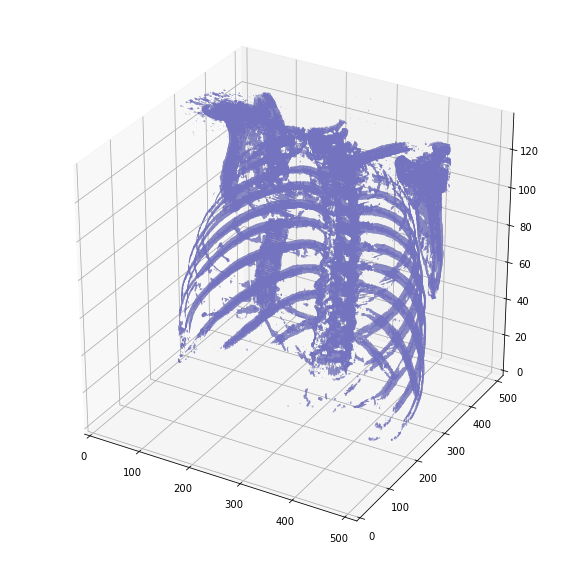

In [103]:
plot_3d(patient_0_image, 400)

## Binarize per Slice

To drastically cut down on input space, we're going to create binary masks to isolate the ROI (the lungs and assorted lung-structures).

We'll start by initializing a Boolean array.

In [113]:
bw = np.zeros(patient_0_image.shape, dtype=bool)

In [114]:
bw[0][:3,:3]

array([[False, False, False],
       [False, False, False],
       [False, False, False]], dtype=bool)

### Identify the Background - Null Space

Recall how a slice looked.

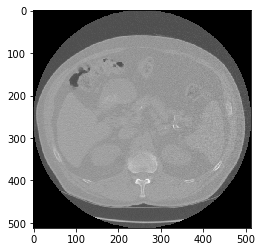

In [143]:
plt.imshow(patient_0_image[0], cmap=plt.cm.gray)

The cross-sections scanned in CT are cylindrical, but the results are recorded in a square grid.
Thus, that black region in the corner is nothing. The first thing to do is to filter that out.

Since the diameter of the circle containing the scan is defined by the width of the box it is in, a robust way of identifying the null points is to mark all points outside this circle as <tt>nan</tt>.

Note the width of each slice.

In [115]:
image_size = patient_0_image.shape[1]

In [116]:
image_size

512

To identify the points outside the circle, we're going to make a corresponding grid that maps each pixel in the slice to it's respective distance from the center of the image.

We can use <tt>linspace</tt> to make a range of same width, centered at zero.

In [125]:
grid_axis = np.linspace(-image_size/2 + 0.5 , image_size/2. - 0.5, image_size)

In [126]:
grid_axis

array([-255.5, -254.5, -253.5, -252.5, -251.5, -250.5, -249.5, -248.5,
       -247.5, -246.5, -245.5, -244.5, -243.5, -242.5, -241.5, -240.5,
       -239.5, -238.5, -237.5, -236.5, -235.5, -234.5, -233.5, -232.5,
       -231.5, -230.5, -229.5, -228.5, -227.5, -226.5, -225.5, -224.5,
       -223.5, -222.5, -221.5, -220.5, -219.5, -218.5, -217.5, -216.5,
       -215.5, -214.5, -213.5, -212.5, -211.5, -210.5, -209.5, -208.5,
       -207.5, -206.5, -205.5, -204.5, -203.5, -202.5, -201.5, -200.5,
       -199.5, -198.5, -197.5, -196.5, -195.5, -194.5, -193.5, -192.5,
       -191.5, -190.5, -189.5, -188.5, -187.5, -186.5, -185.5, -184.5,
       -183.5, -182.5, -181.5, -180.5, -179.5, -178.5, -177.5, -176.5,
       -175.5, -174.5, -173.5, -172.5, -171.5, -170.5, -169.5, -168.5,
       -167.5, -166.5, -165.5, -164.5, -163.5, -162.5, -161.5, -160.5,
       -159.5, -158.5, -157.5, -156.5, -155.5, -154.5, -153.5, -152.5,
       -151.5, -150.5, -149.5, -148.5, -147.5, -146.5, -145.5, -144.5,
      

<tt>meshgrid</tt> will return a 512 x 512 matrix. The first, <tt>x</tt> will have the range going across the rows, and <tt>y</tt> in the columns. Then <tt>x[i,j]</tt> and <tt>y[i,j]</tt> are the Cartesian coordinates of each pixel at indices i, j in the slice if the origin is at the center.

In [127]:
x, y = np.meshgrid(grid_axis, grid_axis)

In [137]:
x

array([[-255.5, -254.5, -253.5, ...,  253.5,  254.5,  255.5],
       [-255.5, -254.5, -253.5, ...,  253.5,  254.5,  255.5],
       [-255.5, -254.5, -253.5, ...,  253.5,  254.5,  255.5],
       ..., 
       [-255.5, -254.5, -253.5, ...,  253.5,  254.5,  255.5],
       [-255.5, -254.5, -253.5, ...,  253.5,  254.5,  255.5],
       [-255.5, -254.5, -253.5, ...,  253.5,  254.5,  255.5]])

In [138]:
y

array([[-255.5, -255.5, -255.5, ..., -255.5, -255.5, -255.5],
       [-254.5, -254.5, -254.5, ..., -254.5, -254.5, -254.5],
       [-253.5, -253.5, -253.5, ..., -253.5, -253.5, -253.5],
       ..., 
       [ 253.5,  253.5,  253.5, ...,  253.5,  253.5,  253.5],
       [ 254.5,  254.5,  254.5, ...,  254.5,  254.5,  254.5],
       [ 255.5,  255.5,  255.5, ...,  255.5,  255.5,  255.5]])

Now we can use this to calculate distance from the origin.

In [139]:
d = (x**2 + y**2)**0.5

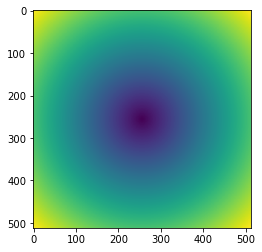

In [141]:
plt.imshow(d)

Now, we're going to identify all the background - null pixels as those whose distance from the center of the image is larger than the radius of the cross-section, which is just half the slice width.

In [151]:
nan_mask = (d < image_size/2).astype(float)

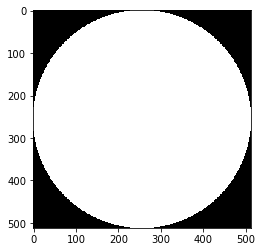

In [152]:
plt.imshow(nan_mask, cmap=plt.cm.gray)

That should do just great. Let's set them all to <tt>nan</tt>.

In [153]:
nan_mask[nan_mask == 0] = np.nan

Now, we want to go through each slice and create a binary mask to segment the lungs from the air. The lower bounds for relevant material are -600 HU, so we choose this as our threshold.

Before we create this mask however, we're going to do two things:
* We're going to check HU values in a box in one of the corners. If they are all the same, we're going to save computation by applying our <tt>nan</tt> mask. If they are not, we leave them be to avoid missing relevant information.
* Next, we apply a gaussian filter across our image. This blurs the image, with the effect of removing noise.
    * This is just a convolution whose output is an average of the neighboring HU values, weighted by discrete approximations to a Gaussian centered at the target pixel. <tt>scipy</tt>'s implementation doesn't discretize an actual multivariate gaussian, it does it in each dimension separately.

Original slice:

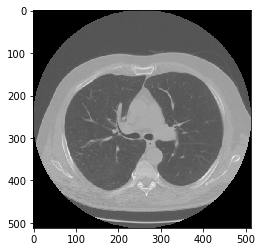

In [173]:
plt.imshow(patient_0_image[80], cmap=plt.cm.gray)

With Gaussian Blur applied:

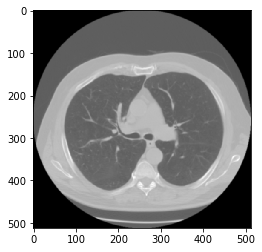

In [174]:
plt.imshow(scipy.ndimage.filters.gaussian_filter(patient_0_image[80], sigma=1, truncate=2.0), cmap=plt.cm.gray)

Now, to build the mask as described.

In [175]:
if len(np.unique(patient_0_image[80,:10,:10])) == 1:
    current_bw = scipy.ndimage.filters.gaussian_filter(np.multiply(patient_0_image[80],nan_mask), sigma=1, truncate=2.0) < -600
else:
    current_bw = scipy.ndimage.filters.gaussian_filter(patient_0_image[80], sigma=1, truncate=2.0) < -600

/home/bckenstler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [176]:
len(np.unique(patient_0_image[80,:10,:10]))

1

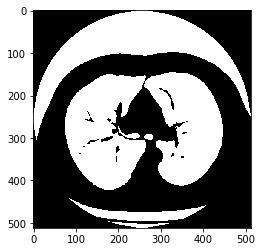

In [177]:
plt.imshow(current_bw.astype(float), cmap=plt.cm.gray)

Next, we mark all unique connected components (contiguous regions of equivalent values).

In [178]:
label = measure.label(current_bw)

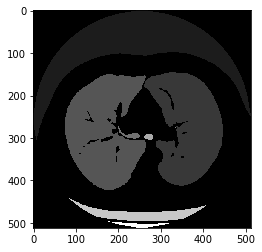

In [180]:
plt.imshow(label, cmap=plt.cm.gray)

For each connected component, we can use <tt>regionprops</tt> to get information about it.

In [181]:
properties = measure.regionprops(label)

In [185]:
valid_label = set()

In [184]:
prop0 = properties[0]

The <tt>area</tt> attribute is the number of pixels in the contiguous region. The <tt>eccentricity</tt> refers to the eccentricity ("elongation") of an ellipse surrounding the region.

In [187]:
prop0.area, prop0.eccentricity

(40960, 0.9174555784325571)

We're going to go through each contiguous region, and keep track of those that have an area larger than 30mm and whose shapes aren't too extreme. In this way, we remove smaller isolated bits and try to get rid of the air pieces, which tend to be very oblong.

In [188]:
for prop in properties:
    if prop.area * spacing[1]*spacing[2] > 30 and prop.eccentricity < 0.99:
        valid_label.add(prop.label)

In [189]:
prop0.label

1

In [190]:
valid_label

{1, 2, 3, 4, 6}

In [194]:
current_bw = np.in1d(label, list(valid_label)).reshape(label.shape)

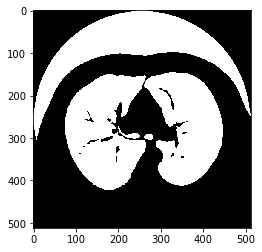

In [195]:
plt.imshow(current_bw, cmap=plt.cm.gray)

Ok, it did a good job but obviously there's still that large air section. We'll come back to that.

### Complete Function

Now we can wrap this up into a function.

In [196]:
def binarize_per_slice(image, spacing, intensity_th=-600, sigma=1, area_th=30, eccen_th=0.99, bg_patch_size=10):
    bw = np.zeros(image.shape, dtype=bool)
    
    # prepare a mask, with all corner values set to nan
    image_size = image.shape[1]
    grid_axis = np.linspace(-image_size/2+0.5, image_size/2-0.5, image_size)
    x, y = np.meshgrid(grid_axis, grid_axis)
    d = (x**2+y**2)**0.5
    nan_mask = (d<image_size/2).astype(float)
    nan_mask[nan_mask == 0] = np.nan
    for i in range(image.shape[0]):
        # Check if corner pixels are identical, if so the slice  before Gaussian filtering
        if len(np.unique(image[i, 0:bg_patch_size, 0:bg_patch_size])) == 1:
            current_bw = scipy.ndimage.filters.gaussian_filter(np.multiply(image[i].astype('float32'), nan_mask), sigma, truncate=2.0) < intensity_th
        else:
            current_bw = scipy.ndimage.filters.gaussian_filter(image[i].astype('float32'), sigma, truncate=2.0) < intensity_th
        
        # select proper components
        label = measure.label(current_bw)
        properties = measure.regionprops(label)
        valid_label = set()
        for prop in properties:
            if prop.area * spacing[1] * spacing[2] > area_th and prop.eccentricity < eccen_th:
                valid_label.add(prop.label)
        current_bw = np.in1d(label, list(valid_label)).reshape(label.shape)
        bw[i] = current_bw
        
    return bw

In [425]:
patient_0_binary_image = binarize_per_slice(patient_0_image, spacing)

/home/bckenstler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


Let's see what this mask looks like.

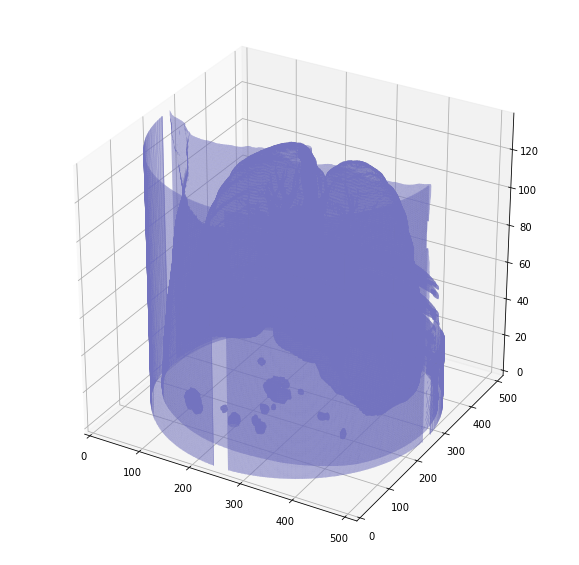

In [200]:
plot_3d(patient_0_binary_image.astype(int), threshold=0)

Yikes, still have some regions that we don't need.

## All-Slice Analysis

In [221]:
patient_0_binary_image_copy = np.copy(patient_0_binary_image)

We start by finding all connected components in the complete binary image. We use 1-connectivity, which only marks regions as contiguous along basis vectors.

In [285]:
label = measure.label(patient_0_binary_image_copy, connectivity=1)

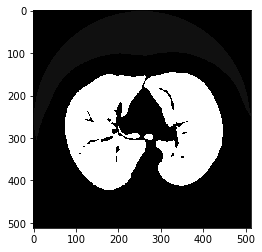

In [292]:
plt.imshow(label[80], cmap=plt.cm.gray)

In [293]:
np.unique(label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

We're going to identify the labels of all the unique connected component regions in the corners of the image, since they're background null space. We're also going to check at edge midpoints, since this is where the air space is.

Midpoint index:

In [264]:
mid = int(label.shape[2] / 2)

In [265]:
mid

256

First we'll identify the labels in the four corners of the bottom slice. 

In [294]:
bg_labels = set([label[0, 0, 0], label[0, 0, -1], label[0, -1, 0], label[0, -1, -1]])

Next, we do the same for the corner points in the last slice.

In [295]:
bg_labels = bg_labels.union([label[-1, 0, 0], label[-1, 0, -1], label[-1, -1, 0], label[-1, -1, -1]])

Finally we get labels of the outermost points along the midpoint line (in one dimension) for each slice.

Just to be clear about what points we're talking about, we mean two antipodal points where the circle touches the edge.

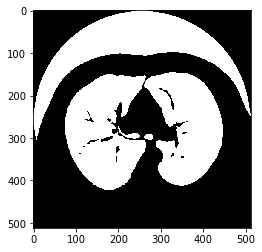

In [296]:
plt.imshow(current_bw, cmap=plt.cm.gray)

In this instance, it will grab the large air region that we failed to set as background in our slice-by-slice binarization.

In [297]:
bg_labels = bg_labels.union([label[0, 0, mid], label[0, -1, mid], label[-1, 0, mid], label[-1, -1, mid]])

Now we can set all these labels as one background label.

In [298]:
for l in bg_labels:
    label[label==l] = 0

In [299]:
np.unique(label)

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])

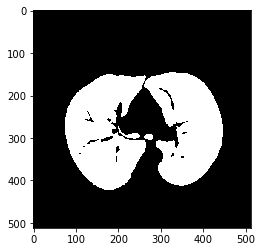

In [300]:
plt.imshow(label[80], cmap=plt.cm.gray)

Perfect, we've removed it!

Now, for the remaining regions in the 3d image we're going to mask all regions whose volume lies outside a range of 0.68 and 7.5 L, using the same region <tt>properties</tt> object. Here, <tt>area</tt> is the number of voxels in the region **volume**. We can calculate the actual volume by multiplying the number of voxels with the dimension it represents, which we've kept track of in <tt>spacing</tt>.

In [301]:
properties = measure.regionprops(label)

In [302]:
for prop in properties:
    if prop.area * spacing.prod() < 0.68 * 1e6 or prop.area * spacing.prod() > 7.5 * 1e6:
        label[label == prop.label] = 0

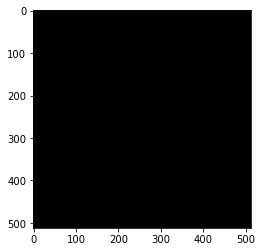

In [303]:
plt.imshow(label[80], cmap=plt.cm.gray)

In [304]:
np.unique(label)

array([0])

Whoops! We've marked everything as background. Why?

It turns out that sometimes the lungs are connected to the air/background space at the top of the scan, so it's removed by the previous step. If we remove some of these top slices until the connection is broken, we can avoid this mistake.

### Remove top slices

Let's take off 20 (I pre-determined this) slices, and re-do the same process of filtering volumes.

In [352]:
cut_num=20

In [353]:
patient_0_binary_image[-cut_num:] = False

In [354]:
label = measure.label(patient_0_binary_image, connectivity=1)

In [357]:
mid = int(label.shape[2] / 2)

In [359]:
bg_labels = set([label[0, 0, 0], label[0, 0, -1], label[0, -1, 0], label[0, -1, -1]])

In [360]:
bg_labels = bg_labels.union([label[-1-cut_num, 0, 0], label[-1-cut_num, 0, -1],
                             label[-1-cut_num, -1, 0], label[-1-cut_num, -1, -1]])

In [362]:
bg_labels = bg_labels.union([label[0, 0, mid], label[0, -1, mid],
                             label[-1-cut_num, 0, mid], label[-1-cut_num, -1, mid]])

In [363]:
for l in bg_labels:
    label[label==l] = 0

In [366]:
properties = measure.regionprops(label)

In [367]:
for prop in properties:
    if prop.area * spacing.prod() < 0.68 * 1e6 or prop.area * spacing.prod() > 7.5 * 1e6:
        label[label == prop.label] = 0

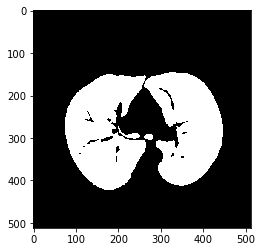

In [368]:
plt.imshow(label[80], cmap=plt.cm.gray)

Great, we've fixed the issue!

Let's look at the remaining contiguous regions.

In [369]:
vols = measure.regionprops(label)

In [374]:
len(vols)

1

In [380]:
vol = vols[0]

There's only 1 left. This might not always be the case.

### Removing large objects far from center

The purpose for the next few steps might not be clear, but I'll do my best to explain at the end.

Like we did when creating the mask for the null background space outside the cylinder, we're going to create a matrix of distance values from the origin centered at the middle of the slice.

In [373]:
x_axis = np.linspace(-label.shape[1]/2+0.5, label.shape[1]/2-0.5, label.shape[1]) * spacing[1]
y_axis = np.linspace(-label.shape[2]/2+0.5, label.shape[2]/2-0.5, label.shape[2]) * spacing[2]
x, y = np.meshgrid(x_axis, y_axis)
d = (x**2+y**2)**0.5

As a reminder:

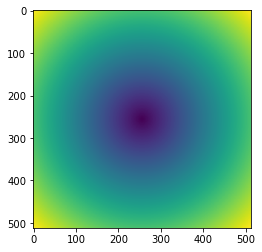

In [683]:
plt.imshow(d)

Now for each remaining 3d region, we binarize the entire space by the corresponding label, and iterate across slices. 
(**Note:** since this particular example only has one distinct volume, this changes nothing but this generally might not be the case)

In [381]:
single_vol = label == vol.label

For each slice, we're going to keep track of two things:
* The area of the region in that slice, in <tt>slice_area</tt>
* the minimum distance between the region and center axis in that slice, in <tt>min_distance</tt>

In [382]:
slice_area = np.zeros(label.shape[0])
min_distance = np.zeros(label.shape[0])

The area is calculated as before, as the number of voxels times the physical dimensions.

In [384]:
np.sum(single_vol[80]) * np.prod(spacing[1:3])

36872.328761577606

Next, find the minimum distance by multiplying the mask for this slice with the distance array. If we then fill the zeros with the maximum distance value, we can take the minimum of this entire array to get the minimum distance of the region with the center axis.

A really simple way to visualize what we're doing is as an overlay of the distance matrix onto the region mask.

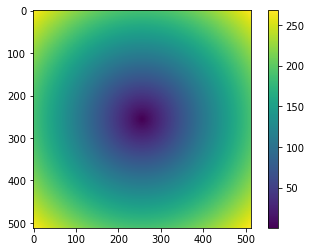

In [686]:
imgshow = plt.imshow(d)
plt.colorbar()

All the background values are set the maximum distance possible.

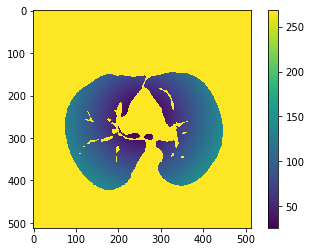

In [685]:
imgplot = plt.imshow(single_vol[80] * d + (1 - single_vol[80]) * np.max(d))
plt.colorbar()

The reason we do this is so that when we take the minimum of this matrix, the value returned is the distance of the ROI pixel closest to the center of the image.

In [388]:
np.min(single_vol[80] * d + (1 - single_vol[80]) * np.max(d))

25.843705790114182

We'll do this for all slices.

In [389]:
for i in range(label.shape[0]):
    slice_area[i] = np.sum(single_vol[i]) * np.prod(spacing[1:3])
    min_distance[i] = np.min(single_vol[i] * d + (1-single_vol[i])*np.max(d))

Ok, now we have minimum distances of the region in each slice. We're going to take the average, but we're going to omit the minimum distance from regions whose area is smaller than $6000mm^{2}$

If that average minimum distance is less than 62 mm from the center axis, we keep this component as valid.

In [390]:
if np.average([min_distance[i] for i in range(label.shape[0]) if slice_area[i] > 6e3]) < 62:
    valid_label.add(vol.label)

Finally, we remake our complete mask as only segmenting those valid labels.

In [392]:
bw = np.in1d(label, list(valid_label)).reshape(label.shape)

Ok, this whole step might be pretty confusing. What did we just do, and why?

Basically, the idea is to remove **large** objects whose average distance from the center axis is greater than what it would be for lungs. The only large objects that should be included in our mask are the lungs, any other additional regions should be bits and pieces of lung matter and things. 

Since we know how far lungs are from the center of the axis, we can remove those large objects that are further than that. What might these objects be? For one, they could be the large regions of air or background that we may have somehow missed up to this point. Or, it could be some other weird thing, the point is we don't want it.

By limiting the inclusion of minimum distances in the average to those whose area is large, we accomplish two things:
* If the large object has some oblong shape, we want the average distance to the center to be measured on the **bulk** of the object, not the smaller ends that might be really close or far to the center.
* If the object is never or only frequently this large, it's likely an object of interest, and ommitting these distances makes it likely the average will be lower than the threshold.

### Filling in the top pieces

The last thing we need to to is fill in the top pieces of the mask that we removed earlier. Obviously, if this image didn't require this then this step is skipped.

We'll make the first copy.

In [394]:
bw1 = np.copy(bw)

We're going to insert the removed values from the original copy we made earlier into this one.

In [397]:
bw1[-cut_num:] = patient_0_binary_image_copy[-cut_num:]

Now, we're going to make a second copy of our final mask, and apply a dilation filter to it.

A **dilation filter** is a morphological operation that applies a filter across the input image. In the binary case, if any value under the kernel is non-zero, then the center value is mapped to zero. This of course has the effect of expanding or *dilating* the region or volume.

**Dilation Example in 2d**

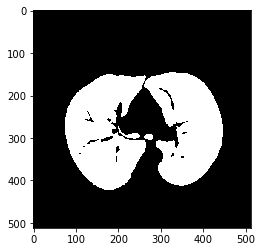

In [688]:
plt.imshow(single_vol[80], cmap=plt.cm.gray)

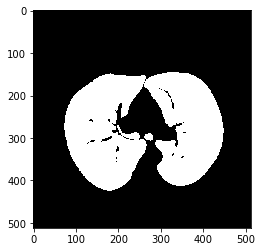

In [689]:
plt.imshow(scipy.ndimage.binary_dilation(single_vol[80]), cmap=plt.cm.gray)

It's easy to understand what it's doing. Moving on.

In [398]:
bw2 = np.copy(bw)

We do as many dilation passes as there are removed slices. The reason we do this is because we wish to expand the regions from the mask into the empty space above it that was removed, in a manner that is contiguous. However, the surface can only expand up one slice per iteration, therefore we do it for as many slices as necessary.

In [400]:
bw2 = scipy.ndimage.binary_dilation(bw2, iterations=cut_num)

Let's see what these two masks look like:
* <tt>bw1</tt>: Where we just inserted the original top
* <tt>bw2</tt>: Where we dilated back into the missing space

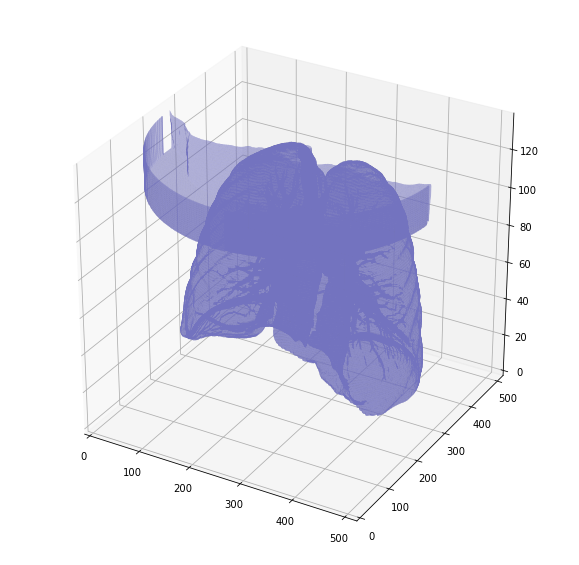

In [403]:
plot_3d(bw1.astype(int), 0)

We can see in the first copy, the removed slices attached to the top, with all the stuff we don't want included.

Looking at the dilated image:

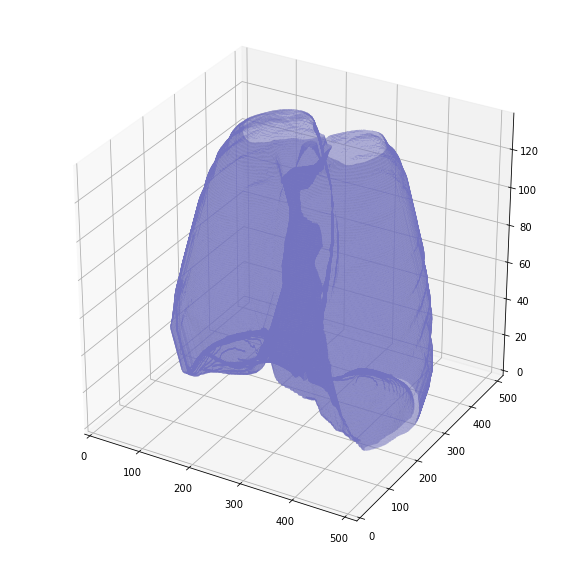

In [404]:
plot_3d(bw2.astype(int), 0)

We want to attach the stuff we do want to the top, in a manner that is contiguous.

We can do this by taking the intersection of these two images.

In [411]:
bw3 = bw1 & bw2

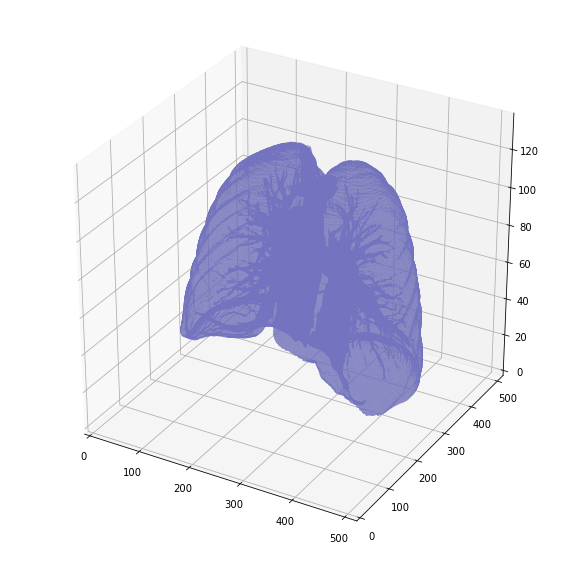

In [413]:
plot_3d(bw3.astype(int), 0)

Now that we've successfully added the top back on, we just going to make sure that we only include those regions from the mask <tt>bw</tt> that exist in the same space in <tt>bw3</tt>.

We get labels for each.

In [414]:
label = measure.label(bw, connectivity=1)

In [415]:
label3 = measure.label(bw3, connectivity=1)

Take all of the non-zero regions.

In [416]:
l_list = list(set(np.unique(label))-{0})

In [417]:
l_list

[1]

For each region, take the indices they correspond to.

In [419]:
indices = np.nonzero(label==l_list[0])

Check the first point from these indices in the region space of the intersection, <tt>bw3</tt>. If it is non-zero, then the label is valid.

In [420]:
label3[indices[0][0], indices[1][0], indices[2][0]]

1

We do this for all regions.

In [421]:
valid_l3 = set()
for l in l_list:
    indices = np.nonzero(label==l)
    l3 = label3[indices[0][0], indices[1][0], indices[2][0]]
    if l3 > 0:
        valid_l3.add(l3)

In [422]:
valid_l3

{1}

Finally, the mask is defined as all regions in the intersection that are valid as we just defined.

In [423]:
bw = np.in1d(label3, list(valid_l3)).reshape(label3.shape)

### Complete function

In [435]:
def all_slice_analysis(bw, spacing, cut_num=0, vol_limit=[0.68, 8.2], area_th=6e3, dist_th=62):
    # in some cases, several top layers need to be removed first
    if cut_num > 0:
        bw0 = np.copy(bw)
        bw[-cut_num:] = False
    label = measure.label(bw, connectivity=1)
    # remove components access to corners
    mid = int(label.shape[2] / 2)
    bg_label = set([label[0, 0, 0], label[0, 0, -1], label[0, -1, 0], label[0, -1, -1], \
                    label[-1-cut_num, 0, 0], label[-1-cut_num, 0, -1], label[-1-cut_num, -1, 0], label[-1-cut_num, -1, -1], \
                    label[0, 0, mid], label[0, -1, mid], label[-1-cut_num, 0, mid], label[-1-cut_num, -1, mid]])
    for l in bg_label:
        label[label == l] = 0
        
    # select components based on volume
    properties = measure.regionprops(label)
    for prop in properties:
        if prop.area * spacing.prod() < vol_limit[0] * 1e6 or prop.area * spacing.prod() > vol_limit[1] * 1e6:
            label[label == prop.label] = 0
            
    if len(np.unique(label)) == 1:
        return bw, 0
    
    # prepare a distance map for further analysis
    x_axis = np.linspace(-label.shape[1]/2+0.5, label.shape[1]/2-0.5, label.shape[1]) * spacing[1]
    y_axis = np.linspace(-label.shape[2]/2+0.5, label.shape[2]/2-0.5, label.shape[2]) * spacing[2]
    x, y = np.meshgrid(x_axis, y_axis)
    d = (x**2+y**2)**0.5
    vols = measure.regionprops(label)
    valid_label = set()
    # select components based on their area and distance to center axis on all slices
    for vol in vols:
        single_vol = label == vol.label
        slice_area = np.zeros(label.shape[0])
        min_distance = np.zeros(label.shape[0])
        for i in range(label.shape[0]):
            slice_area[i] = np.sum(single_vol[i]) * np.prod(spacing[1:3])
            min_distance[i] = np.min(single_vol[i] * d + (1 - single_vol[i]) * np.max(d))
        
        if np.average([min_distance[i] for i in range(label.shape[0]) if slice_area[i] > area_th]) < dist_th:
            valid_label.add(vol.label)
            
    if len(valid_label) == 0:
        return bw, 0
    
    bw = np.in1d(label, list(valid_label)).reshape(label.shape)
    
    # fill back the parts removed earlier
    if cut_num > 0:
        # bw1 is bw with removed slices, bw2 is a dilated version of bw, part of their intersection is returned as final mask
        bw1 = np.copy(bw)
        bw1[-cut_num:] = bw0[-cut_num:]
        bw2 = np.copy(bw)
        bw2 = scipy.ndimage.binary_dilation(bw2, iterations=cut_num)
        bw3 = bw1 & bw2
        label = measure.label(bw, connectivity=1)
        label3 = measure.label(bw3, connectivity=1)
        l_list = list(set(np.unique(label)) - {0})
        valid_l3 = set()
        for l in l_list:
            indices = np.nonzero(label==l)
            l3 = label3[indices[0][0], indices[1][0], indices[2][0]]
            if l3 > 0:
                valid_l3.add(l3)
        bw = np.in1d(label3, list(valid_l3)).reshape(label3.shape)
    
    return bw, len(valid_label)


Notice at the very end, we return the length of the <tt>valid_label</tt> list. Note, this is not the valid list from the last step, this is the one from removing the larger far-from-center regions.

We track this length, because if the lungs in question are connected to the outside space then they are removed in the step prior when filtering by volume. If that's the case, then there is only 1 region in the space, which is the background, and <tt>measure.regionprops()</tt> returns nothing and <tt>valid_label</tt> is empty.

When the length comes back as zero, it's an indication that slices need to be removed from the top. The implementation on a new mask looks like this:

In [436]:
bw = patient_0_binary_image
flag = 0
cut_num = 0
cut_step = 2
bw0 = np.copy(bw)
while flag == 0 and cut_num < bw.shape[0]:
    print(cut_num)
    bw = np.copy(bw0)
    bw, flag = all_slice_analysis(bw, spacing, cut_num=cut_num, vol_limit=[0.68,7.5])
    cut_num = cut_num + cut_step

0
2
4
6
8
10
12
14
16
18
20


We increase by 2 slices to save time.

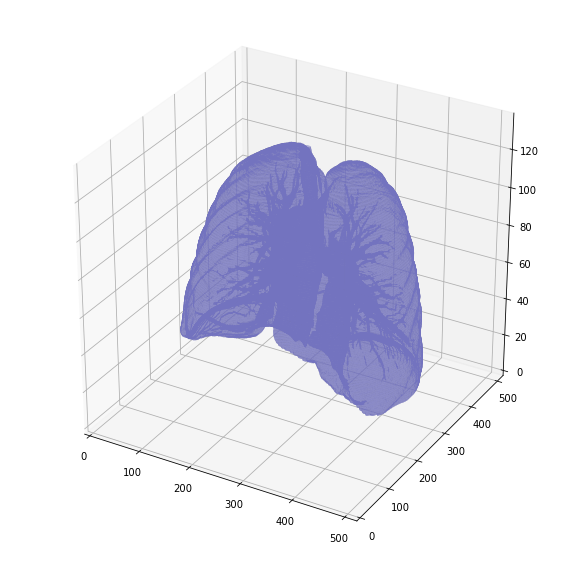

In [437]:
plot_3d(bw.astype(int), 0)

## Fill Hole

Looking at the 3d plot of our segmentation so far, we can make out that there are plenty of tiny holes in the  interior of the lungs. **Note:** The branches are not actually inside, they are connected to the background.

Let's look at how many components we have.

In [444]:
label = measure.label(~bw)

Indeed, the number of unique connected volumes inside is quite large.

In [458]:
len(np.unique(label))

434

What we want to do is find the regions that comprise the background space.

In [449]:
bg_label = set([label[0, 0, 0], label[0, 0, -1], label[0, -1, 0], label[0, -1, -1], \
                label[-1, 0, 0], label[-1, 0, -1], label[-1, -1, 0], label[-1, -1, -1]])

Now, we're going to segment the space into the background region/ not-background region. Since we made sure the lungs are closed surfaces (with branch space), we can be confident that doing this declares the entire space contained by the lungs as one connected region. 

This has the effect of filling in all these tiny holes.

In [451]:
bw_no_holes = ~np.in1d(label, list(bg_label)).reshape(label.shape)

Indeed, this successfully segments the space into 2 contiguous volumes.

In [452]:
np.unique(measure.label(bw_test))

array([0, 1])

It's difficult to see the difference.

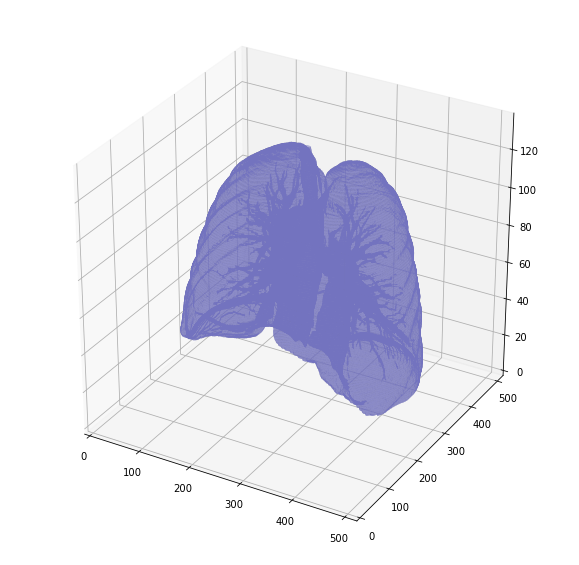

In [454]:
plot_3d(bw_no_holes, 0)

But if we plot the difference before and after...

/home/bckenstler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  """Entry point for launching an IPython kernel.


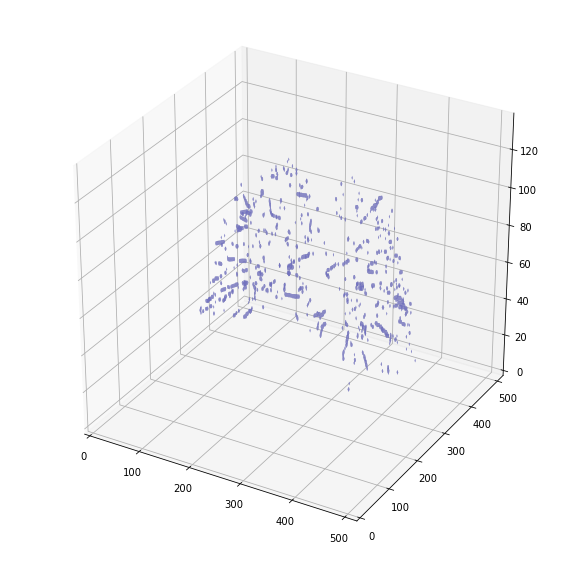

In [457]:
plot_3d(bw_test - bw, 0)

We can see all the tiny holes we filled.

In [482]:
bw = bw_test

### Complete function

In [459]:
def fill_hole(bw):
    label = measure.label(~bw)
    bg_labels = set([label[0, 0, 0], label[0, 0, -1], label[0, -1, 0], label[0, -1, -1], \
                     label[-1, 0, 0], label[-1, 0, -1], label[-1, -1, 0], label[-1, -1, -1]])
    bw = ~np.in1d(label, list(bg_labels)).reshape(label.shape)
    
    return bw

## Two Lung Masks

We can still refine these masks further by segmenting two separate regions, one for each lung, and build a convex shell containing each lung. 

In [462]:
bw0 = np.copy(bw)

We're going to label the space again.

In [463]:
label = measure.label(bw, connectivity=2)

In [465]:
properties = measure.regionprops(label)

In [466]:
properties.sort(key = lambda x: x.area, reverse = True)

In [469]:
len(properties)

1

Since there are only two regions, properties only has one isolated contiguous space, that of the lungs.

### Erosion Split

Next, we're going to apply a binary **erosion** filter. This works in the opposite way of dilation: if any value in the kernel space is 0, then the target pixel is 0, which effectively erodes the surface.

**2d Example**

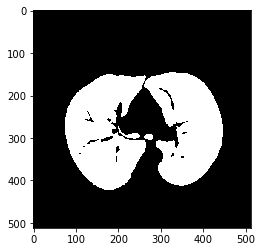

In [688]:
plt.imshow(single_vol[80], cmap=plt.cm.gray)

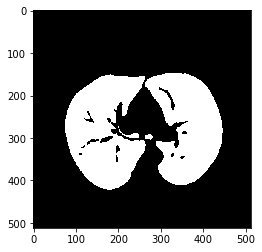

In [690]:
plt.imshow(scipy.ndimage.binary_erosion(single_vol[80]), cmap=plt.cm.gray)

Simple operation.

In [473]:
bw_erosion = scipy.ndimage.binary_erosion(bw)

We can see the overall size is smaller, and the airways interior has grown larger.

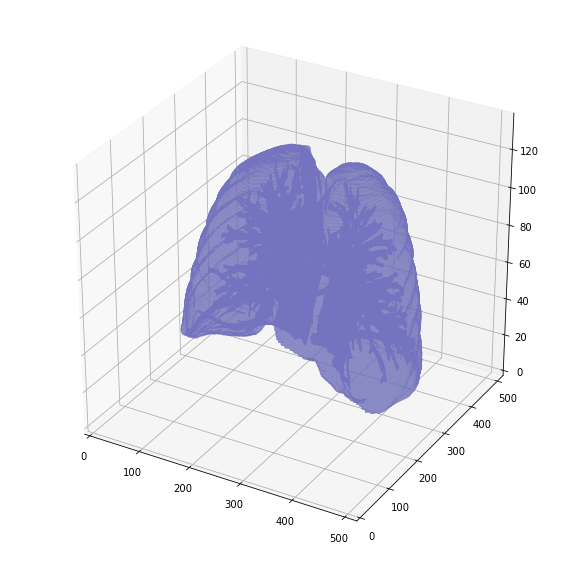

In [475]:
plot_3d(bw_erosion.astype(int), 0)

If we keep eroding the mask, eventually we'll separate the two lungs. However, we want to make sure the volumes are similar in size, so once the regions have split we'll keep eroding until the larger region is less than 4.8x the volume of the smaller.

The conditional loop looks like this:

In [483]:
max_iter = 22
max_ratio = 4.8
found_flag = False
iter_count = 0
bw0 = np.copy(bw)
while not found_flag and iter_count < max_iter:
    label = measure.label(bw, connectivity=2)
    properties = measure.regionprops(label)
    properties.sort(key=lambda x: x.area, reverse=True)
    if len(properties) > 1 and properties[0].area/properties[1].area < max_ratio:
        found_flag = True
        bw1 = label == properties[0].label
        bw2 = label == properties[1].label
    else:
        bw = scipy.ndimage.binary_erosion(bw)
        iter_count = iter_count + 1

In [479]:
bw = np.copy(bw0)

Once we've split into two regions, <tt>properties</tt> will be greater than one, and we stop once the two largest regions have a satisfactory ratio. At this point, we make two masks, one for each separate lung region.

In [484]:
iter_count

1

It's hard to directly see the split.

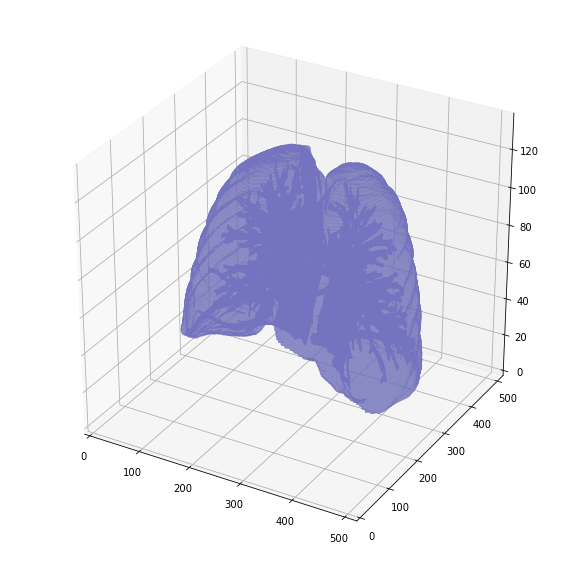

In [486]:
plot_3d(bw.astype(int), 0)

We can look at each separately.

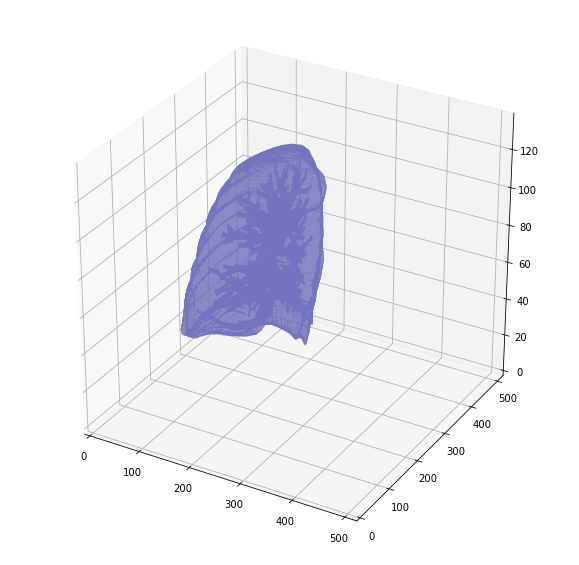

In [487]:
plot_3d(bw1.astype(int), 0)

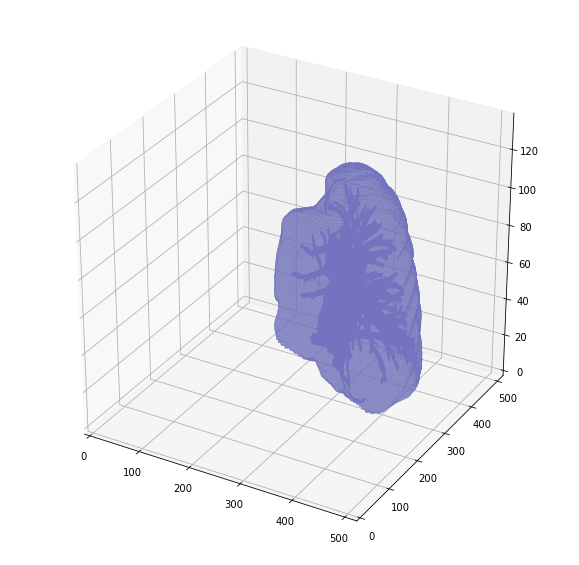

In [488]:
plot_3d(bw2.astype(int), 0)

### Recovering Original Halves

Now we have two masks, one for each half of the **eroded** lung. But what we want are two masks for each half of the original lung. A smart idea is to simply take two intersections of the original mask, one with the portion of space that is close the the left eroded lung, and same for the right.

In order to do this, we're going to make two distance matrices, one for each half, that describe how far each background voxel is from the given half.

We do this with <tt>distance_transform_edt</tt>, which calculates a matrix where each element is the distance from the corresponding voxel to the nearest lung voxel. **Note**: by passing the voxel dims <tt>spacing</tt> into argument <tt>sampling</tt>, the function knowns the unit length along each axis, and therefore we actually find the closest voxel in physical space.

In [489]:
d1 = scipy.ndimage.morphology.distance_transform_edt(bw1==False, sampling=spacing)
d2 = scipy.ndimage.morphology.distance_transform_edt(bw2==False, sampling=spacing)

Let's visualize a slice of these two distance matrices.

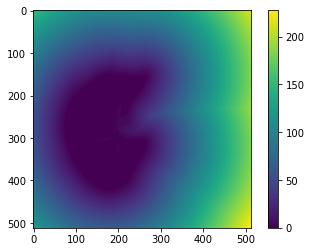

In [693]:
imgshow = plt.imshow(d1[80])
plt.colorbar()

It should be apparent now what these matrices are.

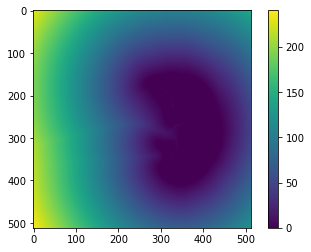

In [694]:
imgshow = plt.imshow(d2[80])
plt.colorbar()

Next, we can split the whole space into two disjoint spaces:
* The portion of the space that's closest to lung half 1: d1 < d2
* The portion of the space that's closest to lung half 2: d2 < d1

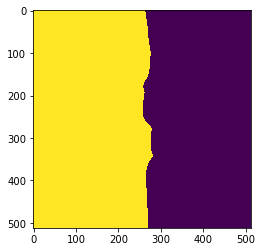

In [695]:
plt.imshow(d1[80] < d2[80])


We can see what the split looks like for a given slice.

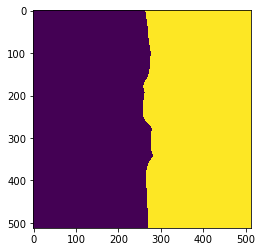

In [696]:
plt.imshow(d1[80] > d2[80])


We can visualize the splitting surface in 3d:

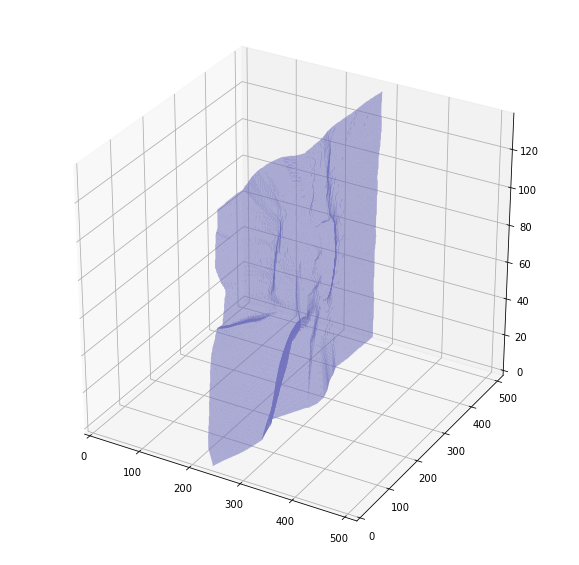

In [697]:
plot_3d((d1 < d2).astype(int), 0)

If we take intersections of these spaces with the original mask, we'll have two separate masks whose union is the origin and whose intersection is empty (in other words, the splits don't overlap).

In [491]:
bw1 = bw0 & (d1 < d2)
bw2 = bw0 & (d2 < d1)

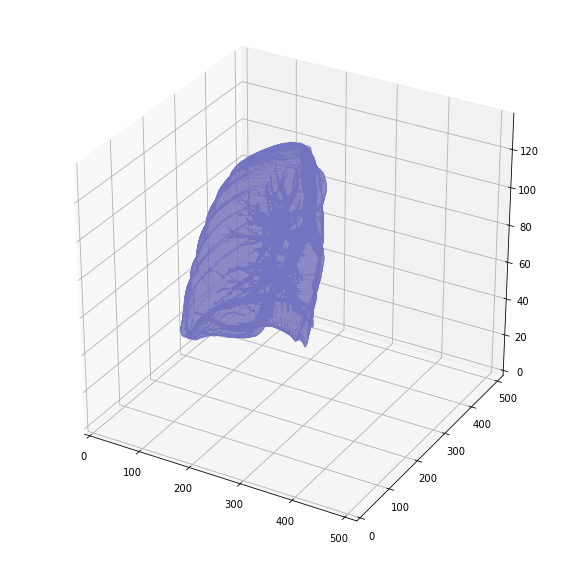

In [490]:
plot_3d(bw1.astype(int), 0)

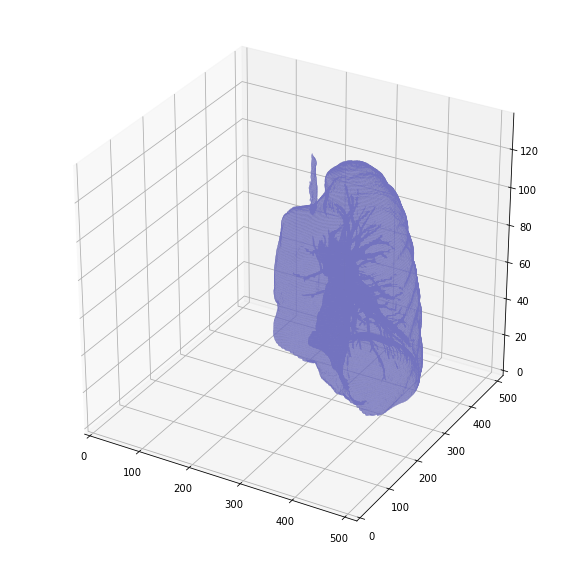

In [492]:
plot_3d(bw2.astype(int), 0)

Obviously the split isn't perfect yet.

### Extract Main

Now that we've split the original mask, we're ready for the final steps.

Let's look at a slice of one of our masks 

In [502]:
current_slice = bw1[80]

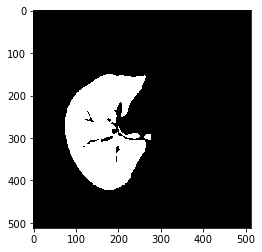

In [503]:
plt.imshow(current_slice, cmap=plt.cm.gray)

So far, we've gotten rid of alot of excess junk and our lungs are sealed.

Now we're going to take it a step further by extracting the main component of the image, and getting rid of everything else. 

For a given slice, we're going to label all connected components and sort by their area.

In [522]:
label = measure.label(current_slice)
properties = measure.regionprops(label)
properties.sort(key=lambda x: x.area, reverse=True)
area = [prop.area for prop in properties]

Next, we collect all components that comprise at least 95% of the total connected component areas, from largest to smallest.

In [523]:
cover=0.95
count = 0
sum = 0
while sum < np.sum(area)*cover:
    sum = sum+area[count]
    count = count+1

We're going to make a filter.

In [524]:
filter = np.zeros(current_slice.shape, dtype=bool)

In [526]:
count

1

This slice has one region that makes up at least 95% of the region space.

The region properties object contains an attribute <tt>bbox</tt>, which as you might guess contains a description of the bounding box around that region.

In [527]:
bb = properties[0].bbox

In [551]:
filter[bb[0]:bb[2], bb[1]:bb[3]] = 1

Let's visualize.

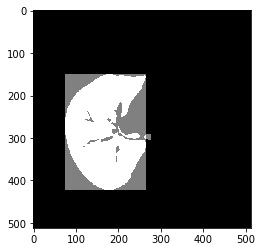

In [552]:
plt.imshow(current_slice.astype(int) + filter, cmap=plt.cm.gray)

We can see the two smaller regions, one of which isn't covered by the box.

More importantly, there is an attribute called <tt>convex_image</tt>, which as you might is a convex shape outlining the region.

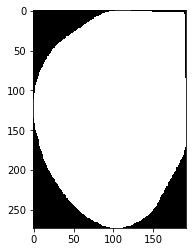

In [556]:
plt.imshow(properties[0].convex_image, cmap=plt.cm.gray)

However, as you can tell this is defined in the bounding box region. We want to go ahead and stick it into the bounding box region of the whole image. We can do that by unioning this convex image with the space of the filter that corresponds to the box it's drawn in.

In [557]:
filter = np.zeros(current_slice.shape, dtype=bool)

In [558]:
filter[bb[0]:bb[2], bb[1]:bb[3]] = filter[bb[0]:bb[2], bb[1]:bb[3]] | properties[0].convex_image

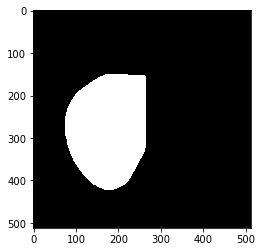

In [560]:
plt.imshow(filter, cmap=plt.cm.gray)

Great! Let's visualize the overlay.

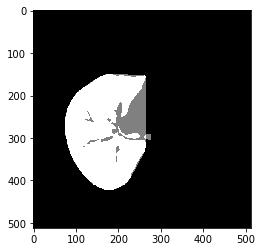

In [562]:
plt.imshow(current_slice.astype(int)+filter, cmap=plt.cm.gray)

Again, that piece is sticking out of the convex image. The final mask for this slice will be the intersection of the convex image (plural if we had more than one) and the original mask.

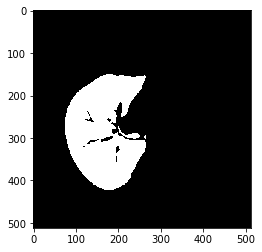

In [564]:
plt.imshow(current_slice & filter, cmap=plt.cm.gray)

For the entire image:

In [566]:
for i in range(bw1.shape[0]):
    current_slice = bw1[i]
    label = measure.label(current_slice)
    properties = measure.regionprops(label)
    properties.sort(key=lambda x: x.area, reverse=True)
    area = [prop.area for prop in properties]
    count = 0
    sum = 0
    while sum < np.sum(area)*cover:
        sum = sum+area[count]
        count = count+1
    filter = np.zeros(current_slice.shape, dtype=bool)
    for j in range(count):
        bb = properties[j].bbox
        filter[bb[0]:bb[2], bb[1]:bb[3]] = filter[bb[0]:bb[2], bb[1]:bb[3]] | properties[j].convex_image
    bw1[i] = bw1[i] & filter

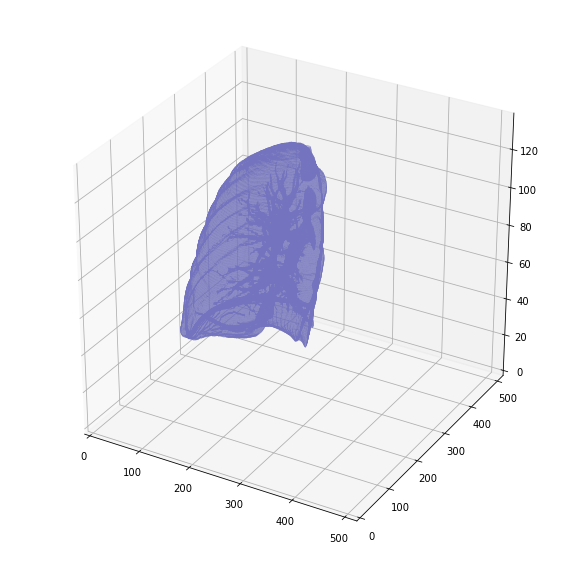

In [568]:
plot_3d(bw1.astype(int), 0)

Even though we've removed many noisy/small components, we still only want the largest.

We include only the largest volume in the final mask, and keep the rest as background.

In [570]:
label = measure.label(bw1)
properties = measure.regionprops(label)
properties.sort(key=lambda x: x.area, reverse=True)
bw1 = label==properties[0].label

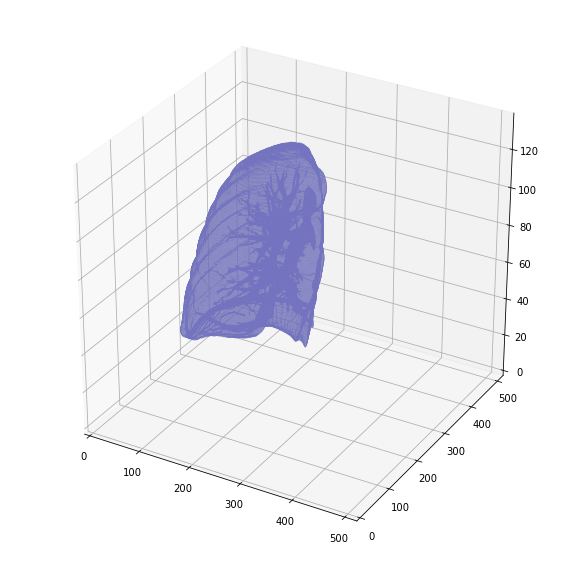

In [572]:
plot_3d(bw1, 0)

In [573]:
for i in range(bw2.shape[0]):
    current_slice = bw2[i]
    label = measure.label(current_slice)
    properties = measure.regionprops(label)
    properties.sort(key=lambda x: x.area, reverse=True)
    area = [prop.area for prop in properties]
    count = 0
    sum = 0
    while sum < np.sum(area)*cover:
        sum = sum+area[count]
        count = count+1
    filter = np.zeros(current_slice.shape, dtype=bool)
    for j in range(count):
        bb = properties[j].bbox
        filter[bb[0]:bb[2], bb[1]:bb[3]] = filter[bb[0]:bb[2], bb[1]:bb[3]] | properties[j].convex_image
    bw2[i] = bw2[i] & filter

In [574]:
label = measure.label(bw2)
properties = measure.regionprops(label)
properties.sort(key=lambda x: x.area, reverse=True)
bw2 = label==properties[0].label

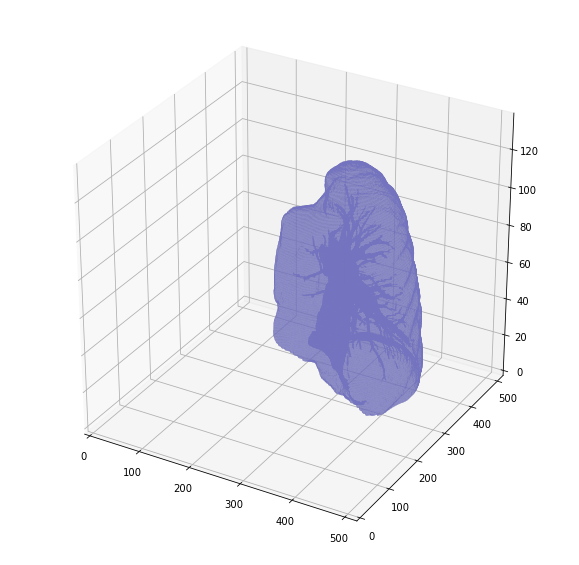

In [575]:
plot_3d(bw2, 0)

### Fill 2D Holes

Now, we're going to go slice by slice and fill in the interior holes of each region.

In [577]:
current_slice = bw1[80]

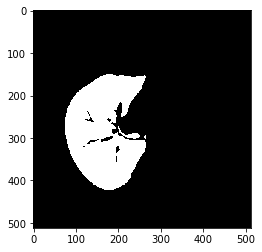

In [576]:
plt.imshow(bw1[80], cmap=plt.cm.gray)

In [578]:
label = measure.label(current_slice)
properties = measure.regionprops(label)

Another attribute to the property object (they just keep coming!) is <tt>filled_image</tt>. If you were guessing this is the filled region, you are correct.

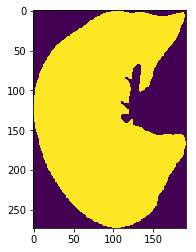

In [585]:
plt.imshow(properties[0].filled_image)

Great. So now we union this with the same space in the original slice to close all the holes.

We'll do this for all of them.

In [586]:
for i in range(bw1.shape[0]):
            current_slice = bw1[i]
            label = measure.label(current_slice)
            properties = measure.regionprops(label)
            for prop in properties:
                bb = prop.bbox
                current_slice[bb[0]:bb[2], bb[1]:bb[3]] = current_slice[bb[0]:bb[2], bb[1]:bb[3]] | prop.filled_image
            bw1[i] = current_slice

In [587]:
for i in range(bw2.shape[0]):
            current_slice = bw2[i]
            label = measure.label(current_slice)
            properties = measure.regionprops(label)
            for prop in properties:
                bb = prop.bbox
                current_slice[bb[0]:bb[2], bb[1]:bb[3]] = current_slice[bb[0]:bb[2], bb[1]:bb[3]] | prop.filled_image
            bw2[i] = current_slice

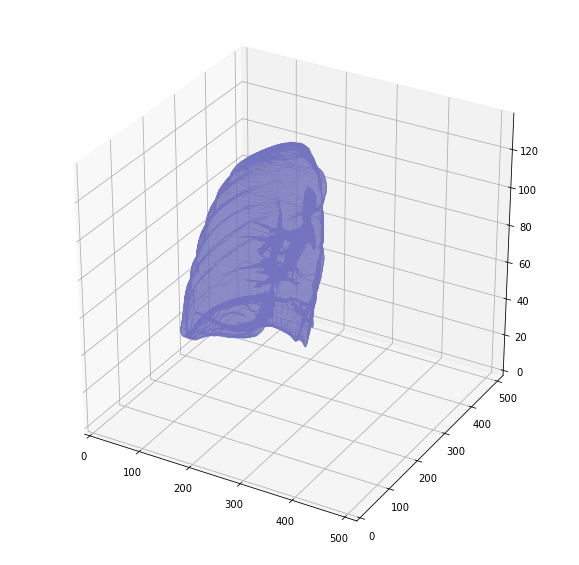

In [588]:
plot_3d(bw1, 0)

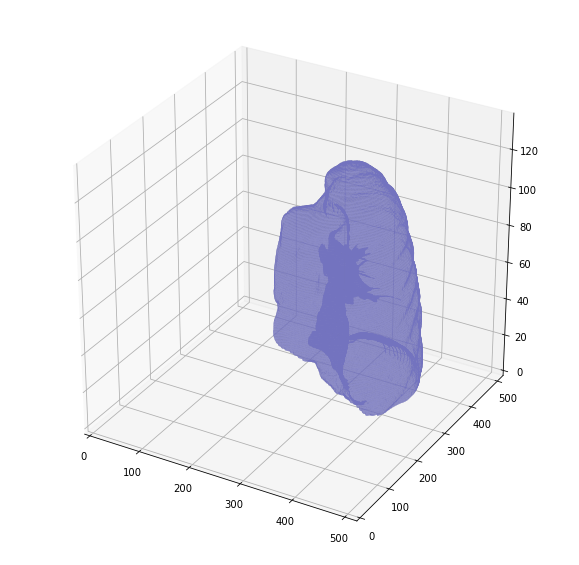

In [589]:
plot_3d(bw2, 0)

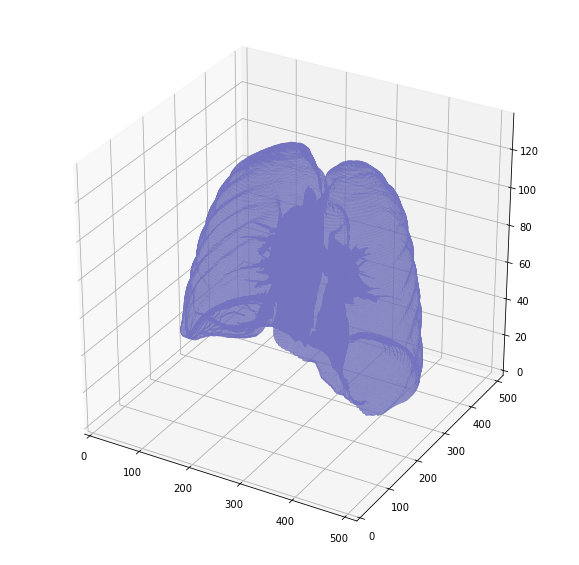

In [590]:
plot_3d(bw1 | bw2, 0)

Wow, we've cleaned the mask up alot!

### Complete function

In [591]:
def two_lung_only(bw, spacing, max_iter=22, max_ratio=4.8):    
    def extract_main(bw, cover=0.95):
        for i in range(bw.shape[0]):
            current_slice = bw[i]
            label = measure.label(current_slice)
            properties = measure.regionprops(label)
            properties.sort(key=lambda x: x.area, reverse=True)
            area = [prop.area for prop in properties]
            count = 0
            sum = 0
            while sum < np.sum(area)*cover:
                sum = sum+area[count]
                count = count+1
            filter = np.zeros(current_slice.shape, dtype=bool)
            for j in range(count):
                bb = properties[j].bbox
                filter[bb[0]:bb[2], bb[1]:bb[3]] = filter[bb[0]:bb[2], bb[1]:bb[3]] | properties[j].convex_image
            bw[i] = bw[i] & filter
           
        label = measure.label(bw)
        properties = measure.regionprops(label)
        properties.sort(key=lambda x: x.area, reverse=True)
        bw = label==properties[0].label

        return bw
    
    def fill_2d_hole(bw):
        for i in range(bw.shape[0]):
            current_slice = bw[i]
            label = measure.label(current_slice)
            properties = measure.regionprops(label)
            for prop in properties:
                bb = prop.bbox
                current_slice[bb[0]:bb[2], bb[1]:bb[3]] = current_slice[bb[0]:bb[2], bb[1]:bb[3]] | prop.filled_image
            bw[i] = current_slice

        return bw
    
    found_flag = False
    iter_count = 0
    bw0 = np.copy(bw)
    while not found_flag and iter_count < max_iter:
        label = measure.label(bw, connectivity=2)
        properties = measure.regionprops(label)
        properties.sort(key=lambda x: x.area, reverse=True)
        if len(properties) > 1 and properties[0].area/properties[1].area < max_ratio:
            found_flag = True
            bw1 = label == properties[0].label
            bw2 = label == properties[1].label
        else:
            bw = scipy.ndimage.binary_erosion(bw)
            iter_count = iter_count + 1
    
    if found_flag:
        d1 = scipy.ndimage.morphology.distance_transform_edt(bw1 == False, sampling=spacing)
        d2 = scipy.ndimage.morphology.distance_transform_edt(bw2 == False, sampling=spacing)
        bw1 = bw0 & (d1 < d2)
        bw2 = bw0 & (d1 > d2)
                
        bw1 = extract_main(bw1)
        bw2 = extract_main(bw2)
        
    else:
        bw1 = bw0
        bw2 = np.zeros(bw.shape).astype('bool')
        
    bw1 = fill_2d_hole(bw1)
    bw2 = fill_2d_hole(bw2)
    bw = bw1 | bw2

    return bw1, bw2, bw

## End-to-end Step1 Process

We've put together all the pieces necessary produce the end-to-end preprocessing for segmenting the lung ROI.

In [592]:
def step1_python(case_path):
    case = load_scan(case_path)
    case_pixels, spacing = get_pixels_hu(case)
    bw = binarize_per_slice(case_pixels, spacing)
    flag = 0
    cut_num = 0
    cut_step = 2
    bw0 = np.copy(bw)
    while flag == 0 and cut_num < bw.shape[0]:
        bw = np.copy(bw0)
        bw, flag = all_slice_analysis(bw, spacing, cut_num=cut_num, vol_limit=[0.68,7.5])
        cut_num = cut_num + cut_step

    bw = fill_hole(bw)
    bw1, bw2, bw = two_lung_only(bw, spacing)
    return case_pixels, bw1, bw2, spacing

In [594]:
case_pixels, bw1, bw2, spacing = step1_python(os.path.join(PATH,patients[100]))

In [597]:
bw = binarize_per_slice(case_pixels, spacing)

We can see the difference between the masks before and after the extensive clean up.

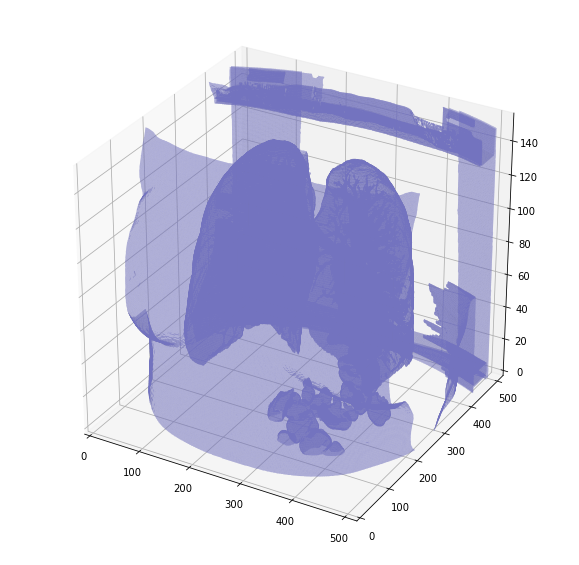

In [599]:
plot_3d(bw.astype(int), 0)

Wow. What a mess!!! 

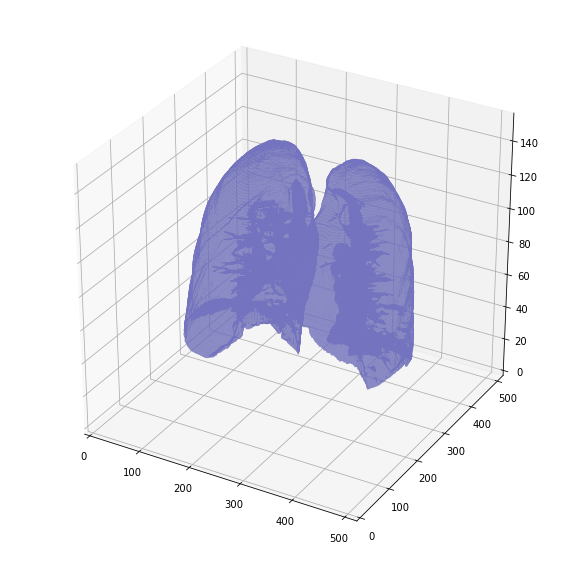

In [595]:
plot_3d(bw1 | bw2, 0)

It's astonishing how robust this entire segmentation process is.

## Preparing Masks for Training Input

We now have a method of segmenting precisely the ROI for each image.

However, there are some alterations we want to make before we finish, changes that will benefit for training.

In [600]:
im, m1, m2, spacing = case_pixels, bw1, bw2, spacing

### Process Mask - Convex Hull & Dilation

We've accomplished stunningly exact segmentation of the lung material. However, we want to make sure that we look at everything in the lung space: we don't want to risk missing nodules that are in branches or attached to outside regions or what-have-you.

To make a mask that covers this entire lung space, we're going to build a convex hull around the lung space and dilate it.

We do this slice by slice.

In [621]:
convex_mask = np.copy(m1)

In [622]:
convex_mask_slice = convex_mask[80]

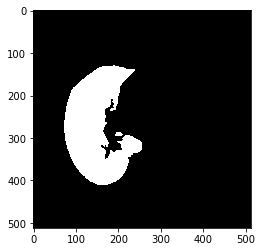

In [624]:
plt.imshow(convex_mask_slice, cmap=plt.cm.gray)

Next, we're going to make a copy of the slice that is contiguous in memory.

In [625]:
mask1  = np.ascontiguousarray(convex_mask_slice)

Compute the convex hull for this slice.

In [627]:
mask2 = convex_hull_image(mask1)

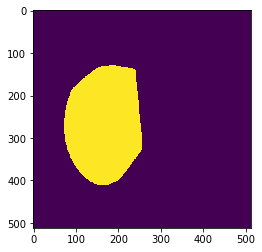

In [628]:
plt.imshow(mask2)

We do this for every slice, ommitting cases where the slice is empty, or if the area of the convex hull is more than twice that of the original region.

In [629]:
convex_mask = np.copy(m1)
for i_layer in range(convex_mask.shape[0]):
    mask1  = np.ascontiguousarray(m1[i_layer])
    if np.sum(mask1)>0:
        mask2 = convex_hull_image(mask1)
        if np.sum(mask2)>2*np.sum(mask1):
            mask2 = mask1
    else:
        mask2 = mask1
    convex_mask[i_layer] = mask2

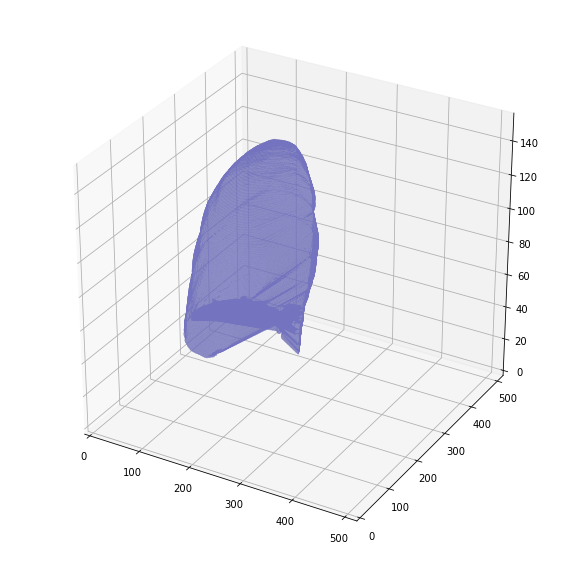

In [630]:
plot_3d(convex_mask, 0)

Great! We've successfully created the convex hull enclosing the lung space, our ROI.

However, this mask is still hugging the lung too tightly. If we dilate it, we can be sure that we don't miss anything by giving ourselves a buffer about the lung.

First we define the kernel we're going to use for dilation.

In [631]:
struct = generate_binary_structure(3,1)  

In [632]:
struct

array([[[False, False, False],
        [False,  True, False],
        [False, False, False]],

       [[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]],

       [[False, False, False],
        [False,  True, False],
        [False, False, False]]], dtype=bool)

Using this kernel, dilation occurs if there are non-zero values one unit away along any primary axis. We're going to apply the filter 10 times.

In [633]:
dilatedMask = binary_dilation(convex_mask,structure=struct,iterations=10) 

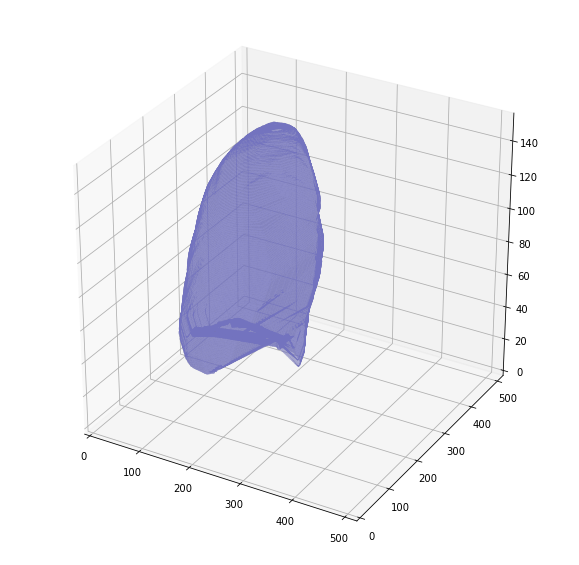

In [634]:
plot_3d(dilatedMask, 0)

#### Complete function

In [635]:
def process_mask(mask):
    convex_mask = np.copy(mask)
    for i_layer in range(convex_mask.shape[0]):
        mask1  = np.ascontiguousarray(mask[i_layer])
        if np.sum(mask1)>0:
            mask2 = convex_hull_image(mask1)
            if np.sum(mask2)>2*np.sum(mask1):
                mask2 = mask1
        else:
            mask2 = mask1
        convex_mask[i_layer] = mask2
    struct = generate_binary_structure(3,1)  
    dilatedMask = binary_dilation(convex_mask,structure=struct,iterations=10) 
    return dilatedMask

In [636]:
dm1 = process_mask(m1)
dm2 = process_mask(m2)

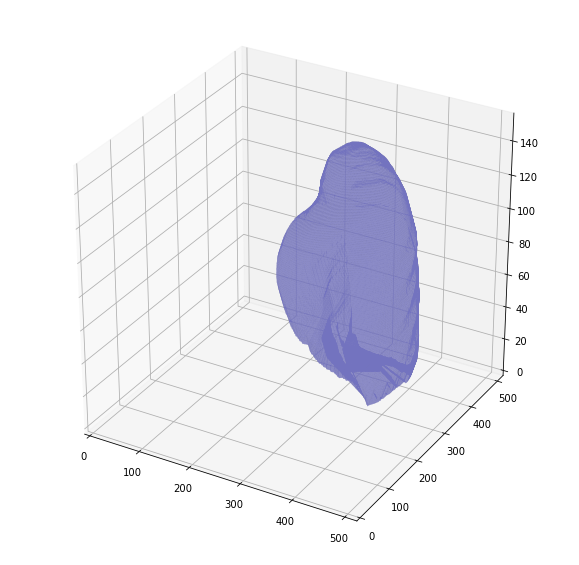

In [638]:
plot_3d(dm2.astype(int), 0)

Comparing the masks, and visualizing the extra dilated space.

In [639]:
dilatedMask = dm1 + dm2
Mask = m1 + m2
extramask = dilatedMask ^ Mask

Dilated mask:

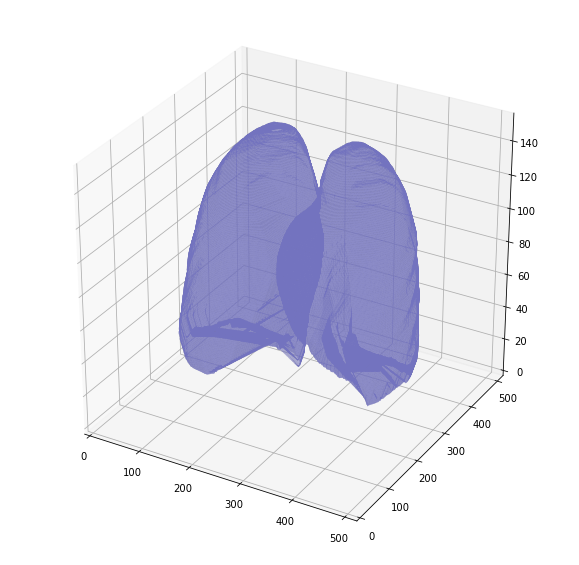

In [641]:
plot_3d(dilatedMask.astype(int), 0)

Original mask:

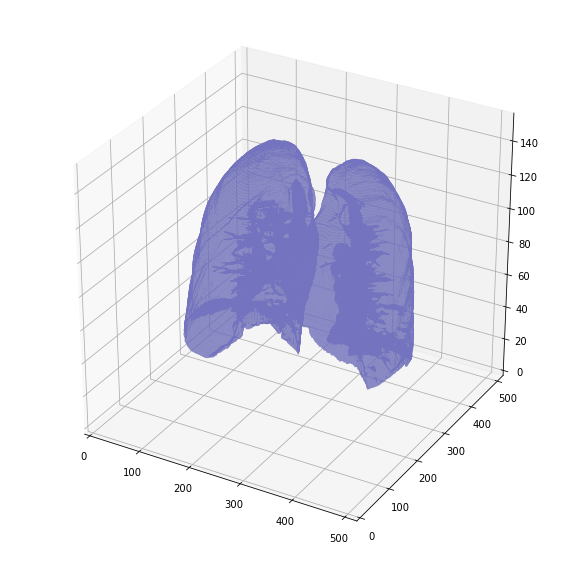

In [642]:
plot_3d(Mask.astype(int), 0)

Extra space from dilation:

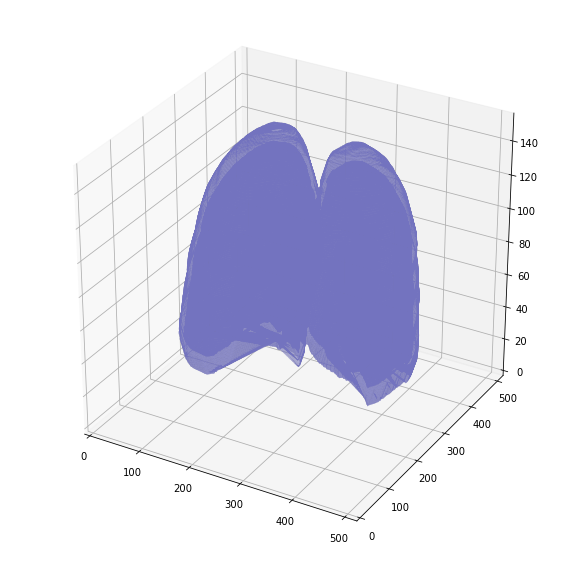

In [643]:
plot_3d(extramask.astype(int), 0)

### Intensity Normalization

Next, we're going to normalize the HU units by clipping them to [-1200, 600] and transforming to an integer scale of [0, 255] so we can feed to a neural network.

The function to do this:

In [644]:
def lumTrans(img):
    lungwin = np.array([-1200.,600.])
    newimg = (img-lungwin[0])/(lungwin[1]-lungwin[0])
    newimg[newimg<0]=0
    newimg[newimg>1]=1
    newimg = (newimg*255).astype('uint8')
    return newimg

Before normalizing, we're going to set any <tt>nan</tt> values to -2000.

In [645]:
im[np.isnan(im)]=-2000
sliceim = lumTrans(im)

Now that we've done this, we're ready to multiply the dilated mask with the input space. We're going to fill the rest of the space with a padding value of 170.

In [646]:
pad_value = 170

In [647]:
sliceim = sliceim*dilatedMask+pad_value*(1-dilatedMask).astype('uint8')

Our dilated space almost assuredly has expanded and covers space occupied by the bones surrounding the lungs. We want to set the bone values to padding as well.

First, we can note the threshold on our transformed scale that bone falls above.

In [648]:
bone_thresh = 210

We're going to label all the voxels in the extra space created from dilation as bone if it lies above the bone threshold.

In [649]:
bones = sliceim*extramask>bone_thresh

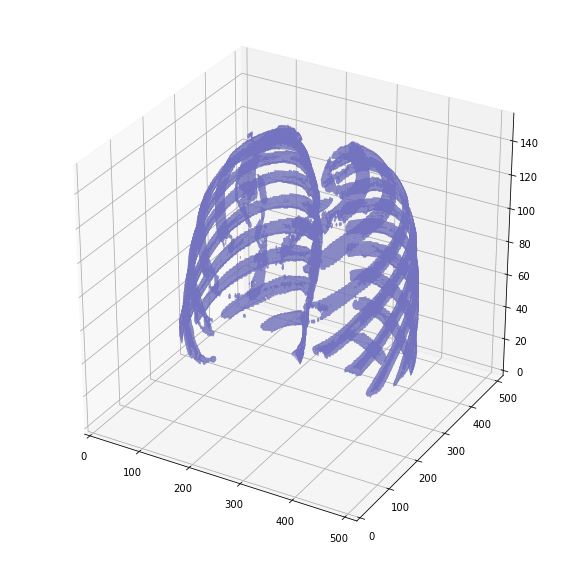

In [651]:
plot_3d(bones.astype(int), 0)

Looks good enough! Now we'll fill those values in with padding.

In [652]:
sliceim[bones] = pad_value

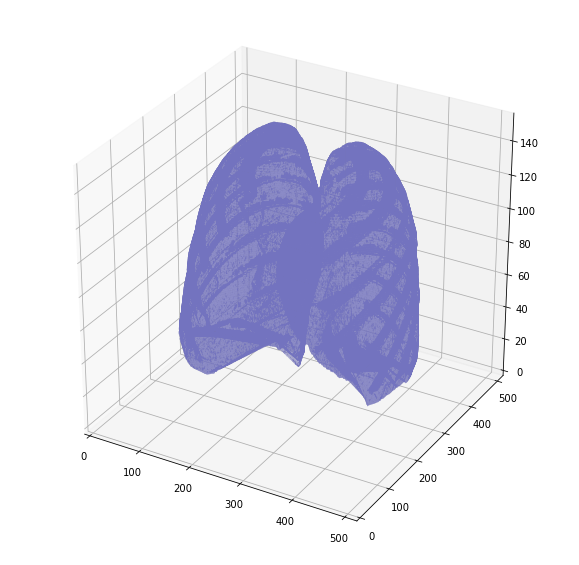

In [653]:
plot_3d((~(sliceim==pad_value)).astype(int), 0)

Great, we can see that we've removed the bone structures from the dilated area.

### Resampling

We've now finally applied our mask, and set padding values / removed bone spaces.

The next step is to resample each image / mask to a standard voxel grid of 1mm x 1mm x 1mm. This is incredibly important if we want to use a neural network: we want each input to have the same physical interpretation.

The reason this is important is because it's easier for the network to learn if it expects each input to have the same physical interpretation. In other words, it's easier to learn given an input space where each voxel is always 1mm x 1mm x 1mm, then one where it could have any dimension (that would require learning some sort of dimensional invariance).

The target dimension is given below.

In [602]:
resolution = np.array([1,1,1])

This function resamples the array to the desired resolution. It does this first by calculating the resize factors for each dimension to transform into the desired spacing. Then we apply the <tt>zoom</tt> function to the input image, with the given resize factors. This function resizes to the desired spacing, using spline interpolation to determine voxel values at the desired granularity.

In [655]:
def resample(imgs, spacing, new_spacing,order = 2):
    if len(imgs.shape)==3:
        new_shape = np.round(imgs.shape * spacing / new_spacing)
        true_spacing = spacing * imgs.shape / new_shape
        resize_factor = new_shape / imgs.shape
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            imgs = zoom(imgs, resize_factor, mode = 'nearest',order=order)
        return imgs, true_spacing
    elif len(imgs.shape)==4:
        n = imgs.shape[-1]
        newimg = []
        for i in range(n):
            slice = imgs[:,:,:,i]
            newslice,true_spacing = resample(slice,spacing,new_spacing)
            newimg.append(newslice)
        newimg=np.transpose(np.array(newimg),[1,2,3,0])
        return newimg,true_spacing
    else:
        raise ValueError('wrong shape')

Note that we're also returning <tt>true_spacing</tt>: Given rounding, we often might not end up exact resize factors. The true spacing tells us what it really is, which is as close to 1x1x1 as we can get.

In [658]:
sliceim1,_ = resample(sliceim,spacing,resolution,order=1)

Ok, now we can make the observation that we don't actually need to save the entire space, just the box around the ROI.

In [660]:
newshape = sliceim1.shape

In [661]:
newshape

(230, 301, 301)

Next, we're going to define the three dimensional bounding box of the mask.

In [662]:
xx,yy,zz= np.where(Mask)

In [663]:
xx, yy, zz

(array([  8,   8,   8, ..., 142, 142, 142]),
 array([356, 357, 357, ..., 303, 303, 303]),
 array([200, 199, 200, ..., 197, 198, 199]))

In [664]:
box = np.array([[np.min(xx),np.max(xx)],[np.min(yy),np.max(yy)],[np.min(zz),np.max(zz)]])

In [665]:
box

array([[  8, 142],
       [116, 424],
       [ 49, 447]])

We're going to transform the box coordinates from the old spacing the new. 

In [666]:
box = box*np.expand_dims(spacing,1)/np.expand_dims(resolution,1)

In [667]:
box

array([[  12.        ,  213.        ],
       [  68.1953125 ,  249.265625  ],
       [  28.80664062,  262.78710938]])

In [668]:
box = np.floor(box).astype('int')

In [669]:
box

array([[ 12, 213],
       [ 68, 249],
       [ 28, 262]])

Now, to be safe we don't actually want to just limit ourselves to the bounding box tangential to the ROI. We'll give ourselves a buffer.

In [670]:
margin = 5

In [671]:
extendbox = np.vstack([np.max([[0,0,0],box[:,0]-margin],0),np.min([newshape,box[:,1]+2*margin],axis=0).T]).T

In [672]:
extendbox = extendbox.astype(int)

In [673]:
extendbox

array([[  7, 223],
       [ 63, 259],
       [ 23, 272]])

Next, we pull out this extended box from our resampled image.

In [674]:
sliceim2 = sliceim1[extendbox[0,0]:extendbox[0,1],
                    extendbox[1,0]:extendbox[1,1],
                    extendbox[2,0]:extendbox[2,1]]

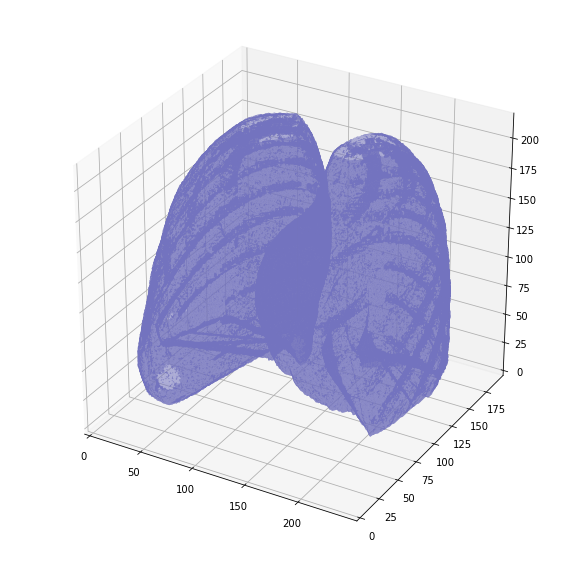

In [677]:
plot_3d((~(sliceim2==pad_value)).astype(int), 0)

And that's it. We're finished preprocessing. Hooray! 

What a journey this has been.

Before saving the array, we're going to add an extra dimension for batches.

In [678]:
sliceim2 = sliceim2[np.newaxis,...]

### Complete function

This is the complete function called to preprocess an image from path, and save it.

In [ ]:
def savenpy(id,filelist,prep_folder,data_path,use_existing=True):      
    resolution = np.array([1,1,1])
    name = filelist[id]
    if use_existing:
        if os.path.exists(os.path.join(prep_folder,name+'_label.npy')) and os.path.exists(os.path.join(prep_folder,name+'_clean.npy')):
            print(name+' had been done')
            return
    try:
        im, m1, m2, spacing = step1_python(os.path.join(data_path,name))
        Mask = m1+m2
        
        newshape = np.round(np.array(Mask.shape)*spacing/resolution)
        xx,yy,zz= np.where(Mask)
        box = np.array([[np.min(xx),np.max(xx)],[np.min(yy),np.max(yy)],[np.min(zz),np.max(zz)]])
        box = box*np.expand_dims(spacing,1)/np.expand_dims(resolution,1)
        box = np.floor(box).astype('int')
        margin = 5
        extendbox = np.vstack([np.max([[0,0,0],box[:,0]-margin],0),np.min([newshape,box[:,1]+2*margin],axis=0).T]).T
        extendbox = extendbox.astype('int')



        convex_mask = m1
        dm1 = process_mask(m1)
        dm2 = process_mask(m2)
        dilatedMask = dm1+dm2
        Mask = m1+m2
        extramask = dilatedMask ^ Mask
        bone_thresh = 210
        pad_value = 170

        im[np.isnan(im)]=-2000
        sliceim = lumTrans(im)
        sliceim = sliceim*dilatedMask+pad_value*(1-dilatedMask).astype('uint8')
        bones = sliceim*extramask>bone_thresh
        sliceim[bones] = pad_value
        sliceim1,_ = resample(sliceim,spacing,resolution,order=1)
        sliceim2 = sliceim1[extendbox[0,0]:extendbox[0,1],
                    extendbox[1,0]:extendbox[1,1],
                    extendbox[2,0]:extendbox[2,1]]
        sliceim = sliceim2[np.newaxis,...]
        np.save(os.path.join(prep_folder,name+'_clean'),sliceim)
        np.save(os.path.join(prep_folder,name+'_label'),np.array([[0,0,0,0]]))
    except:
        print('bug in '+name)
        raise
    print(name+' done')

## Parallelize Please

This is obviously an extremely time-consuming preprocessing process.

The implementation used by the grt123 is to use python's <tt>multiprocessing</tt> to parallelize the task.

If you've never seen this before, this is a great example of how it works. 

A pool of workers is declared (by **workers**, we mean separate processes). We can map this pool of workers to a function and an iterable of elements to apply the function onto. However, the function has to have only one argument, which the iterable is mapped to. To get around this, we use the partial function to define the savenpy function with the additional arguments declared.

Once that's done, we can map the workers to the iterable and let them go.

We want to use as many workers as we can, and this is determined by the number of cores on our machine.

In [682]:
cpu_count()

12

In [679]:
def full_prep(data_path,prep_folder,n_worker = None,use_existing=True):
    warnings.filterwarnings("ignore")
    if not os.path.exists(prep_folder):
        os.mkdir(prep_folder)

            
    print('starting preprocessing')
    pool = Pool(n_worker)
    filelist = [f for f in os.listdir(data_path)]
    partial_savenpy = partial(savenpy,filelist=filelist,prep_folder=prep_folder,
                              data_path=data_path,use_existing=use_existing)

    N = len(filelist)
    _=pool.map(partial_savenpy,range(N))
    pool.close()
    pool.join()
    print('end preprocessing')
    return filelist

And that's it, that's the complete preprocessing implementation used by the winners of the Kaggle Bowl. 

# End